In [1]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Loading and Exploring Data

## Import packages

In [2]:
from plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
import os
import math
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import xgboost           as xgb

from scipy                     import stats
from scipy.stats               import norm
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model      import SGDRegressor
from sklearn                   import svm
from xgboost                   import XGBRegressor,plot_importance
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import f1_score,log_loss
from sklearn.preprocessing     import LabelEncoder
from scipy.stats.stats         import pearsonr
from scipy.special             import boxcox1p

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Packages imported!')
%matplotlib inline

Packages imported!


## Load data¶

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('rows in train dataset:', train.shape[0], ', columns:', train.shape[1])
print('rows in test dataset:', test.shape[0], ', columns:', test.shape[1])

rows in train dataset: 1460 , columns: 81
rows in test dataset: 1459 , columns: 80


In [6]:
# train.describe()

In [7]:
# test.describe()

In [8]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [9]:
test_ID

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [10]:
test_ID.to_csv('test_id.csv',index=False)

## Explore And Visualize The Data

### Remove outliers¶


/home/yasser/anaconda3/envs/AMMI/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


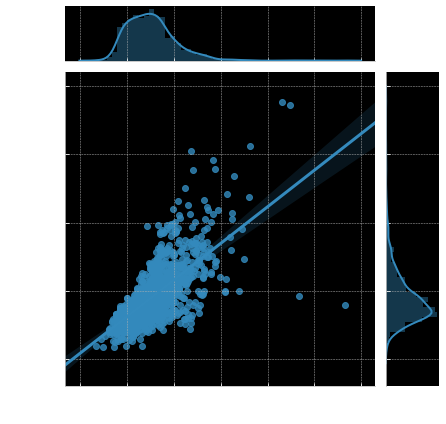

In [11]:
sns.jointplot(x='GrLivArea', y='SalePrice', data=train,kind='reg')

From the plot above: There are 5 observations that we indicate them quickly as outliers. Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately).

In [12]:
# outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

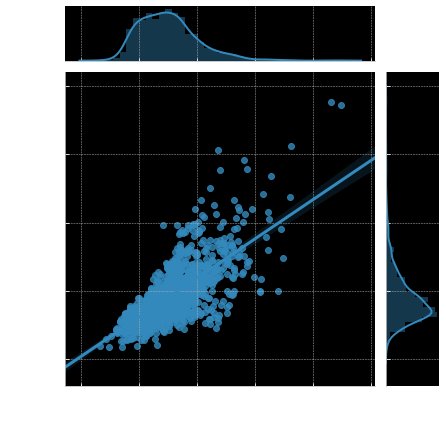

In [13]:
#replotting
sns.jointplot(x ="GrLivArea", y="SalePrice", data=train,kind='reg')

In [14]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# concatenate training and test data into data
data = pd.concat((train, test),sort=False).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("data size is : {}".format(data.shape))

data size is : (2917, 79)


It seems this is a huge dataset and we should know what all columns we have, to understand what to keep and what to drop with the first glance of our dataset.

In [15]:
# Checking Categorical Data
data.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
# Checking Numerical Data
data.select_dtypes(include=['int64','float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

There are 79 columns in our dataset. Do you think they all are important? To understand that whether we should keep a certain column or not, we need to answer quick questions about each of them. For example:

- Do we think about this variable when we are buying a house? (e.g. When we think about the house of our dreams, do we care about its 'Masonry veneer type'?).

- If so, how important would this variable be? (e.g. What is the impact of having 'Excellent' material on the exterior instead of 'Poor'? And of having 'Excellent' instead of 'Good'?).

- Is this information already described in any other variable? (e.g. If 'LandContour' gives the flatness of the property, do we really need to know the 'LandSlope'?).

# Dealing with Missingness

This data set had a lot of missingness, but the data description that came with it basically showed us how to handle most of it

In [17]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(34)

Total    Percent
PoolQC         2908  99.691464
MiscFeature    2812  96.400411
Alley          2719  93.212204
Fence          2346  80.425094
FireplaceQu    1420  48.680151
LotFrontage     486  16.660953
GarageCond      159   5.450806
GarageQual      159   5.450806
GarageYrBlt     159   5.450806
GarageFinish    159   5.450806
GarageType      157   5.382242
BsmtCond         82   2.811107
BsmtExposure     82   2.811107
BsmtQual         81   2.776826
BsmtFinType2     80   2.742544
BsmtFinType1     79   2.708262
MasVnrType       24   0.822763
MasVnrArea       23   0.788481
MSZoning          4   0.137127
BsmtHalfBath      2   0.068564
Utilities         2   0.068564
Functional        2   0.068564
BsmtFullBath      2   0.068564
BsmtFinSF2        1   0.034282
BsmtFinSF1        1   0.034282
Exterior2nd       1   0.034282
BsmtUnfSF         1   0.034282
TotalBsmtSF       1   0.034282
Exterior1st       1   0.034282
SaleType          1   0.034282
Electrical        1   0.034282
KitchenQual       1   0.034282
GarageArea        1   0.034282
GarageCars        1   0.034282

Missing Features:
    - Alley: data desc says na means "no alley access"
    - BsmtQual, BsmtCond, BsmntExposure, BsmtFinType1, BsmtFinType2: data desc says NA means "no basement"
    - FireplaceQU: desc says NA means "No Fireplace"
    - GarageType, GarageFinish,GaraGarageQual, GarageCond: desc says NA means "No Garage"
    - PoolQC: desc says NA means "No Pool"
    - Fence: desc says NA means "No Fence"
    - MiscFeature: desc says NA means "None"

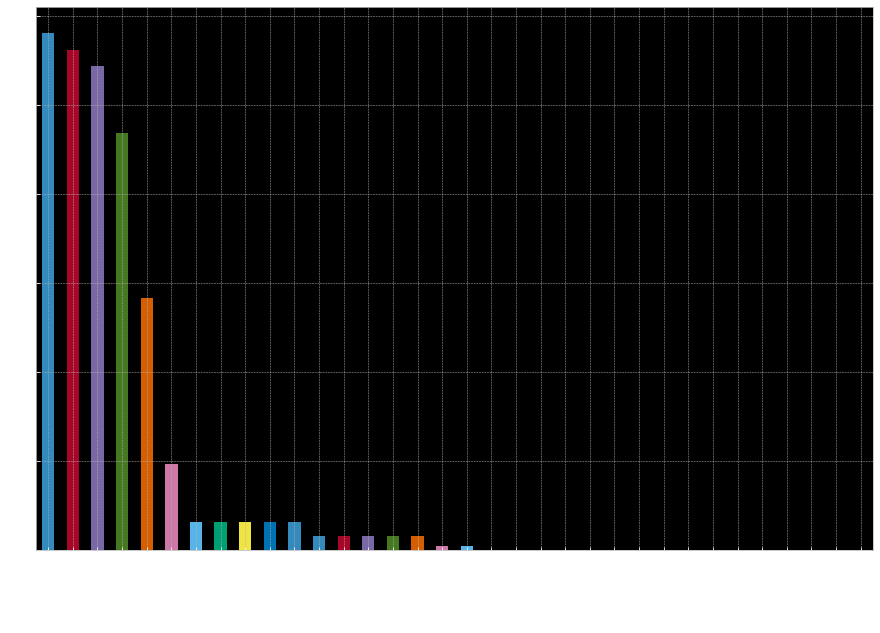

In [18]:
# aggregate all null values 
all_data_na = data.isnull().sum()

# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

In [19]:
# Using data description, fill these missing values with "None"

data["Alley"]        = data["Alley"].fillna("None")
data["BsmtQual"]     = data["BsmtQual"].fillna("None")
data["BsmtCond"]     = data["BsmtCond"].fillna("None")
data["BsmtExposure"] = data["BsmtExposure"].fillna("None")
data["BsmtFinType1"] = data["BsmtFinType1"].fillna("None")
data["BsmtFinType2"] = data["BsmtFinType2"].fillna("None")

data["FireplaceQu"]  = data["FireplaceQu"].fillna("None")
data["GarageType"]   = data["GarageType"].fillna("None")
data["GarageFinish"] = data["GarageFinish"].fillna("None")
data["GarageQual"]   = data["GarageQual"].fillna("None")
data["GarageCond"]   = data["GarageCond"].fillna("None")
data["PoolQC"]       = data["PoolQC"].fillna("None")
data["Fence"]        = data["Fence"].fillna("None")
data["MiscFeature"]  = data["MiscFeature"].fillna("None")

In [20]:
total   = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(8)

Total    Percent
LotFrontage     486  16.660953
GarageYrBlt     159   5.450806
MasVnrType       24   0.822763
MasVnrArea       23   0.788481
MSZoning          4   0.137127
Functional        2   0.068564
BsmtHalfBath      2   0.068564
Utilities         2   0.068564

The area of the lot out front is likely to be similar to the houses in the local neighbourhood

Therefore, let's use the median value of the houses in the neighbourhood to fill this feature

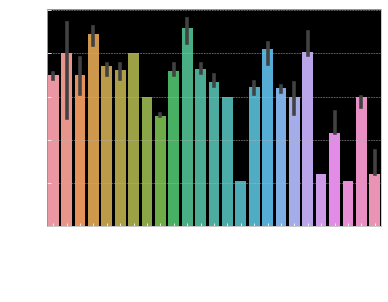

In [21]:
sns.barplot(data=data,x='Neighborhood',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

neighborhood seems a pretty good at determining lot frontage- using the mean neighborhood lot frontage to impute the missing lot frontages

In [22]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

Using data description, fill these missing values with 0 

In [23]:
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0)

most likely no basement so setting these basement measurements to zero

In [24]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

Probably no masonry veneer for these houses so setting to 0 or none

In [25]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

filling the 4 missing zoning's with residential- the most common seen zoning type

In [26]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

filling missing functional with most common type (typ)

In [27]:
data['Functional'] = data['Functional'].fillna("Typ")

removing missing garage cars and area

In [28]:
# only one is null and it has type Detchd
# data['GarageCars'] = data['GarageCars'].fillna(0)
# data['GarageArea'] = data['GarageArea'].fillna(0)

data['GarageCars'] = data.groupby("GarageType")["GarageArea"].transform(lambda x: x.fillna(x.median()))
data['GarageArea'] = data.groupby("GarageType")["GarageArea"].transform(lambda x: x.fillna(x.mean()))

Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features

In [29]:
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['SaleType'   ] = data['SaleType'   ].fillna(data['SaleType'   ].mode()[0])
data['Electrical' ] = data['Electrical' ].fillna(data['Electrical' ].mode()[0])
data['Functional' ] = data['Functional' ].fillna(data['Functional' ].mode()[0])

In [30]:
total   = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

Total   Percent
Utilities          2  0.068564
SaleCondition      0  0.000000
Foundation         0  0.000000
RoofMatl           0  0.000000
Exterior1st        0  0.000000

Here we see that we have 1 remaining feature with missing values, Utilities.

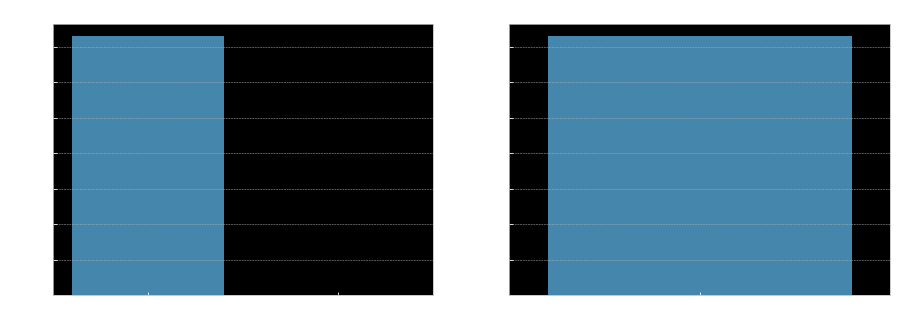

In [31]:
plt.subplots(figsize =(15, 5))

plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")

plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

This tell us that within the training dataset, Utilities has two unique values: "AllPub" and "NoSeWa". With "AllPub" being by far the most common.

However, the test dataset has only 1 value for this column, which means that it holds no predictive power because it is a constant for all test observations.

Therefore, we can drop this column.



In [32]:
data = data.drop(['Utilities'], axis=1)

OK, all the missingness is taken care of!

### Exploratory Data Analysis

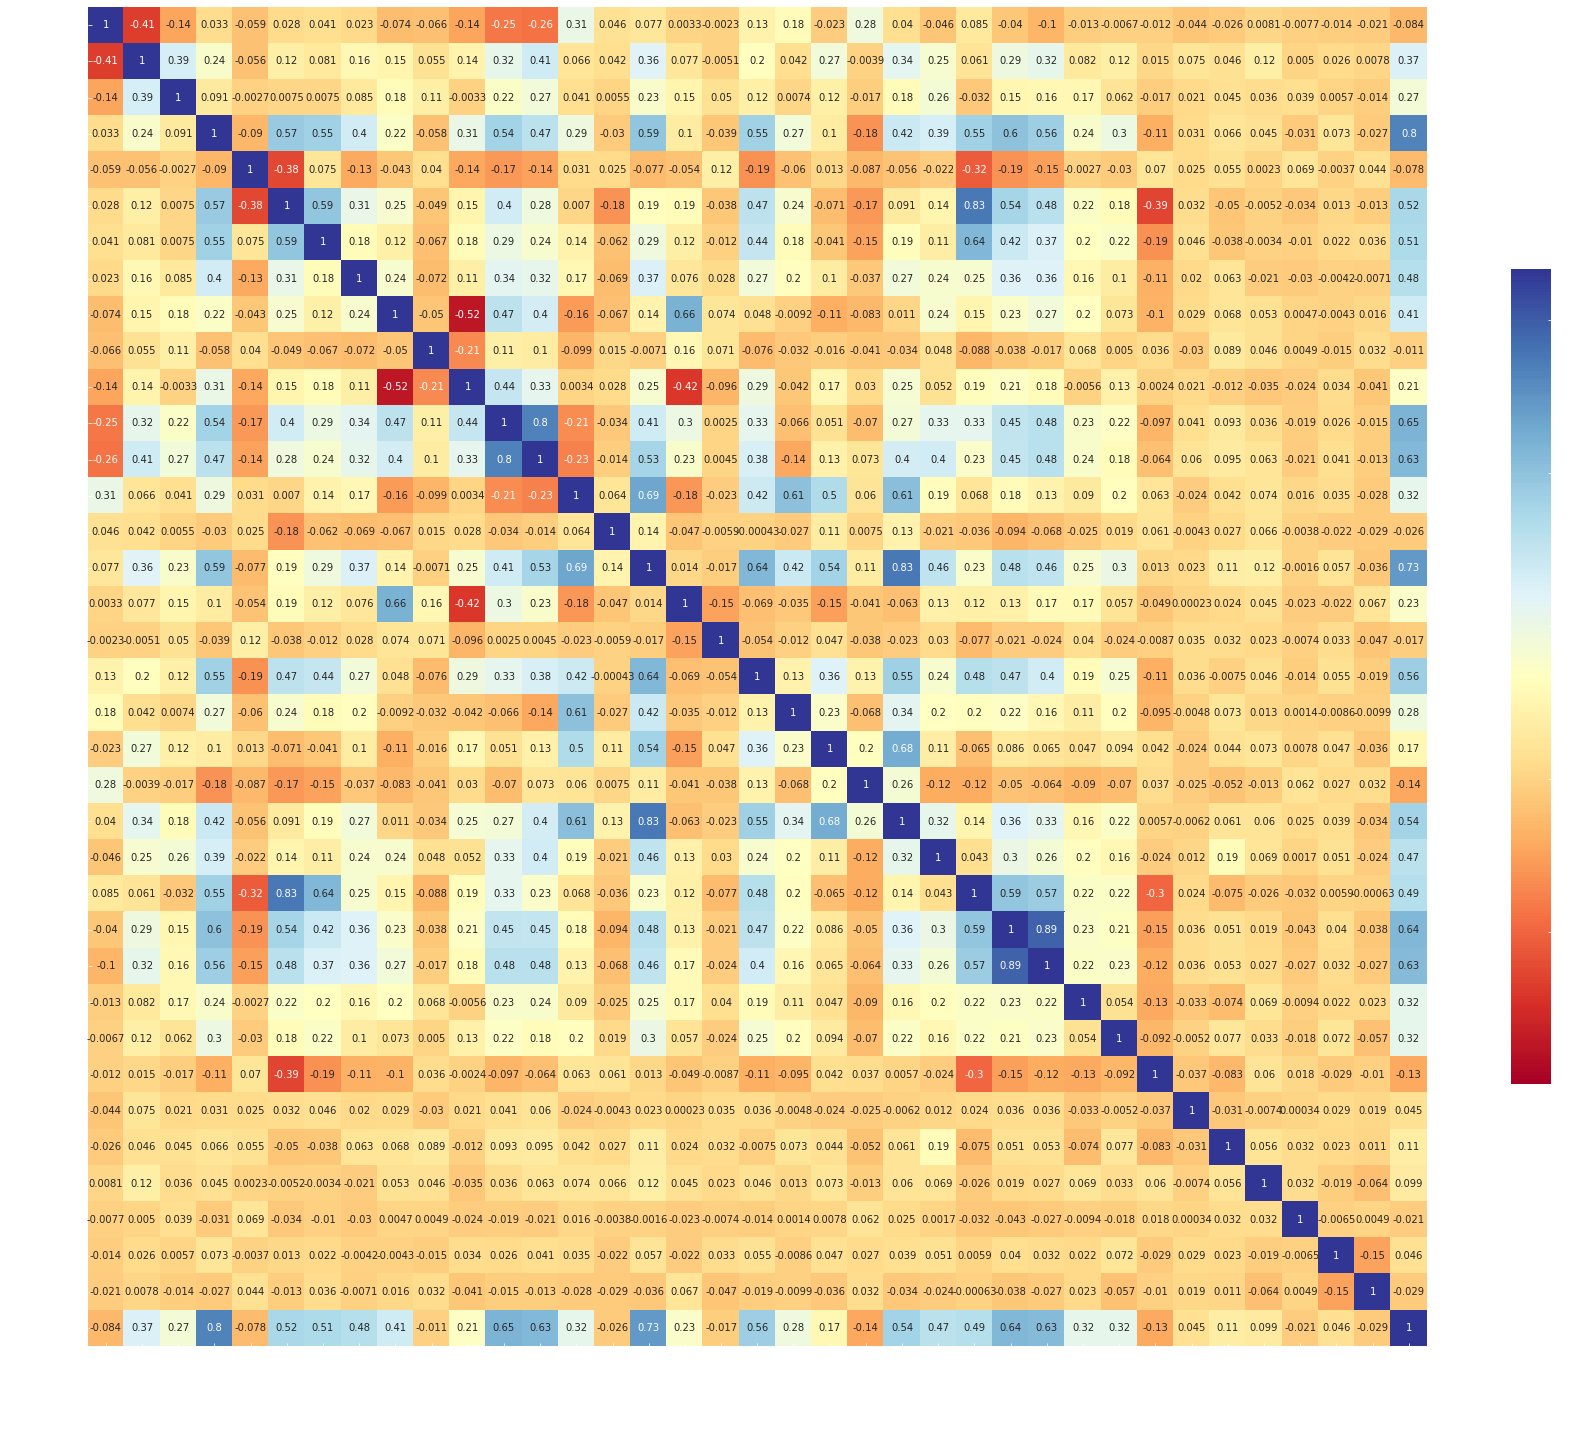

In [33]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2,\
            square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

Using this correlation matrix, I am able to visualise the raw highly influencing factors on SalePrice.
I am looking for these because I will create polynomial features from the highly correlating features, in an attempt to capture the complex non-linear relationships within the data.


This is too huge. We need to narrow it down. Let's make a zoomed style heatmap for our 'SalePrice' by picking up the 10 variable with which our 'SalePrice' has the strongest correlation.

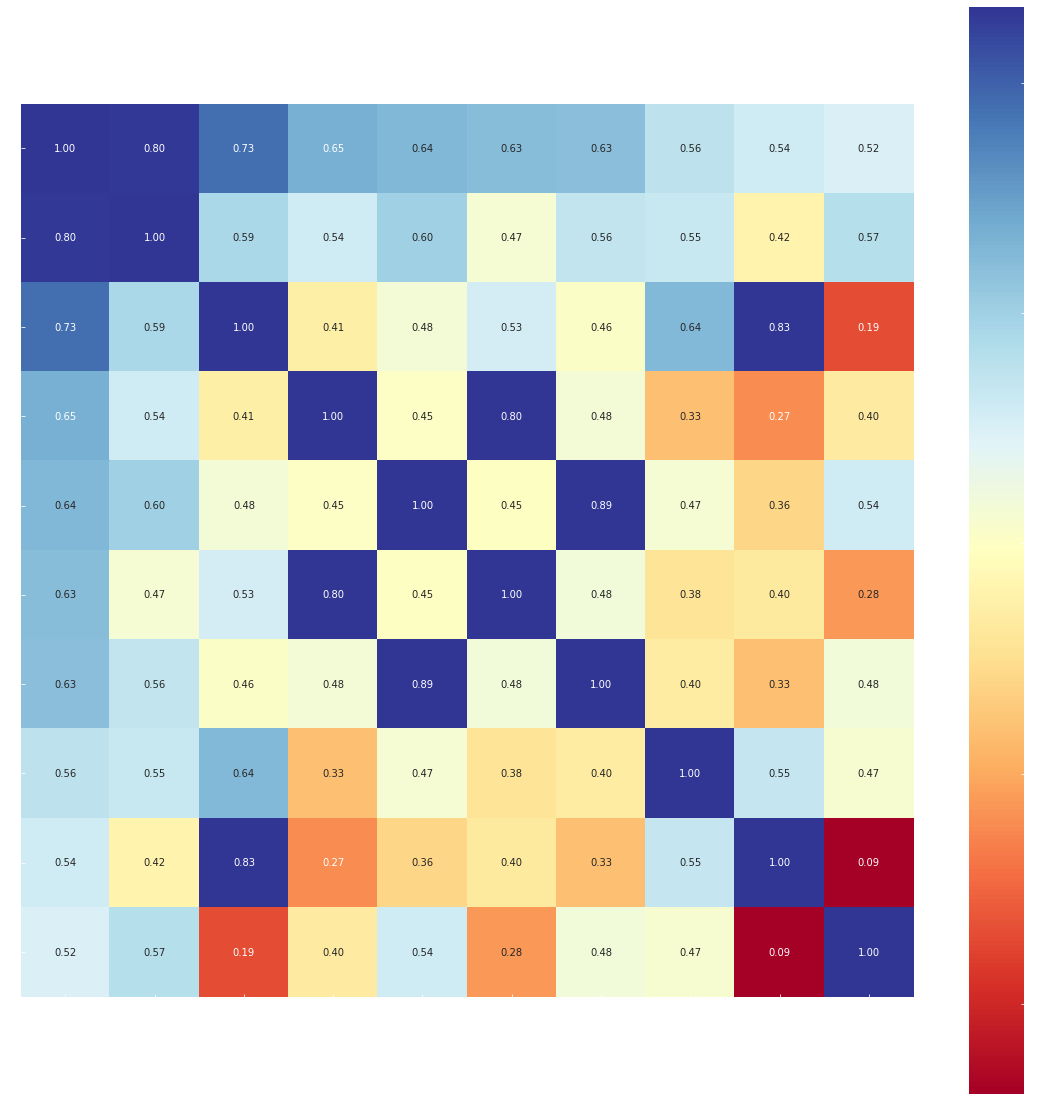

In [34]:
plt.subplots(figsize=(20, 20))
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True,  vmax=.8,annot=True, square=True, fmt='.2f', annot_kws={'size': 10},\
            yticklabels=cols.values, xticklabels=cols.values,cmap='RdYlBu',linecolor="white")

#### Evaluates the height of the basement.

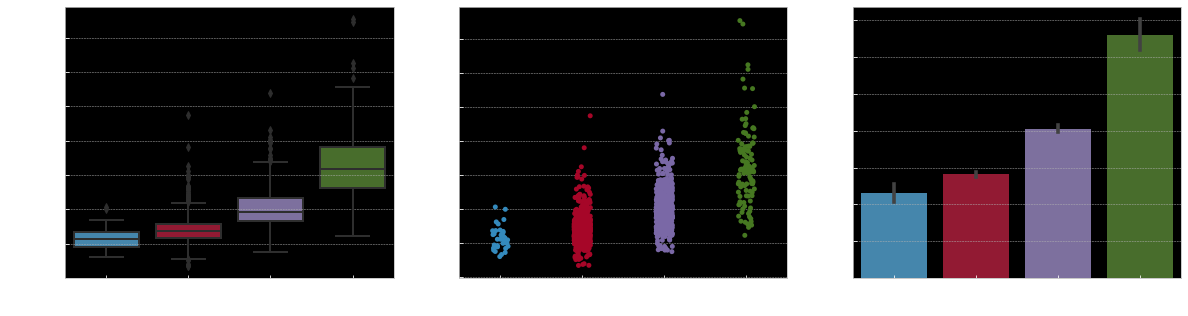

In [35]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

SalePrice is clearly affected by BsmtQual, with the better the quality being meaning the higher the price.
However, it looks as though most houses have either 'Good' or 'Typical' sized basements.
Since this feature is ordinal, i.e. the categories represent different levels of order.

#### Evaluates the general condition of the basement.


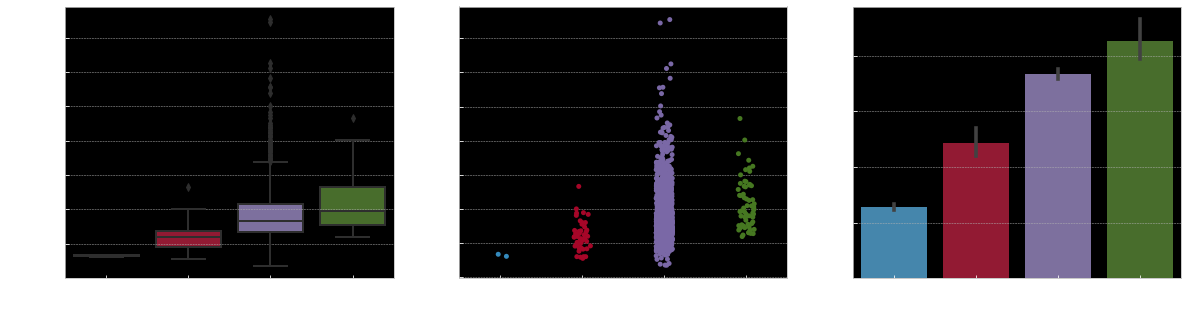

In [36]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);


As the condition of the basement improves, the SalePrice also increases.
However, we see some very high SalePrice values for the houses with "Typical" basement conditions. This perhaps suggests that although these two features correlate positively, BsmtCond may not have a largely influential contribution on SalePrice.
We also see the largest number of houses falling into the "TA" category.


#### Refers to walkout or garden level walls


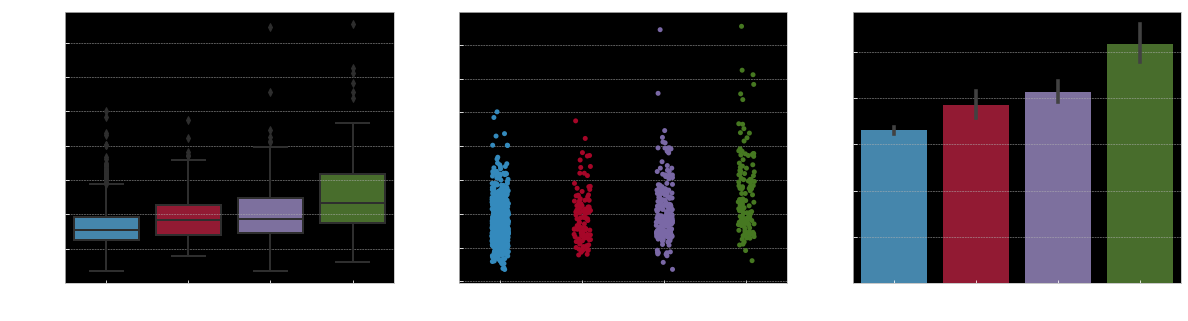

In [37]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtExposure", y="SalePrice", data=train, size = 5, jitter = True, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

As the amount of exposure increases, so does hte typical SalePrice. Interestingly, the average difference of SalePrice between categories is quite low here, telling me that some houses sold for very high prices, even with no exposure.
From this analysis I would say that it is positively correlating with SalePrice, but it isn't massively influential.

#### Rating of basement finished area


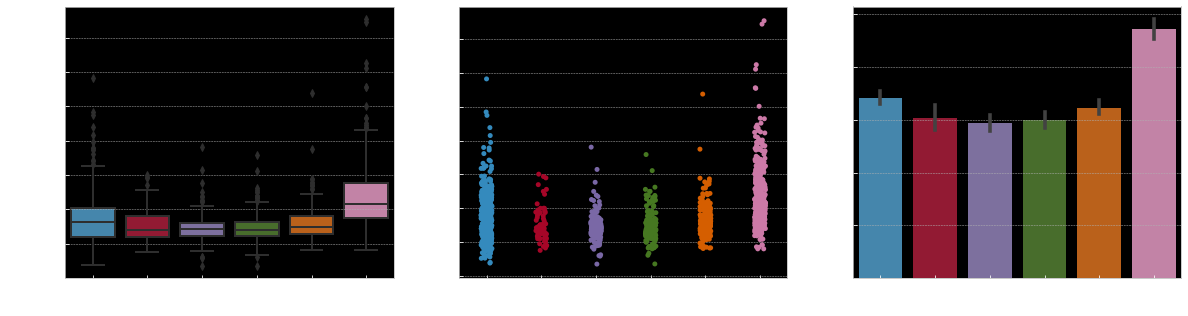

In [38]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType1", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);


This is very interesting, it seems as though houses with an unfinished basement on average sold for more money than houses having up to an average rating...
However, houses with a good finish within the basement still demand more money than unfinished ones.

#### Type 1 finished square feet.


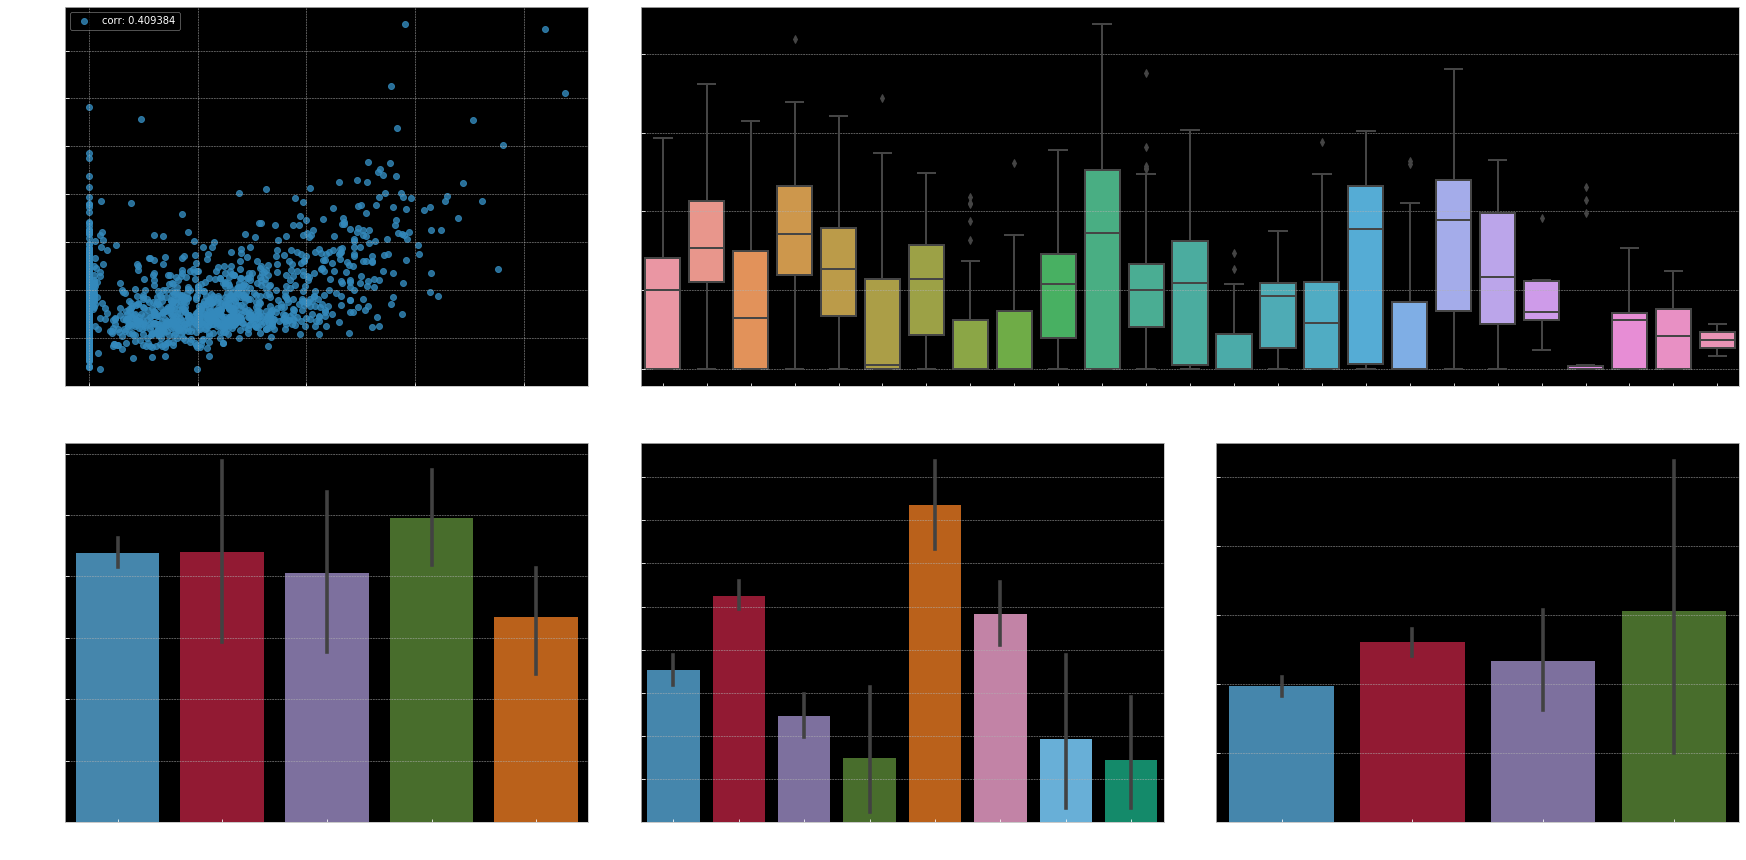

In [39]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF1'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF1'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF1", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF1", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF1", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF1", data=train);

This feature has a positive correlation with SalePrice and the spread of data points is quite large.
It is also clear that the local area (Neighborhood) and style of building (BldgType, HouseStyle and LotShape) has a varying effect on this feature.

#### Rating of basement finished area (if multiple types)


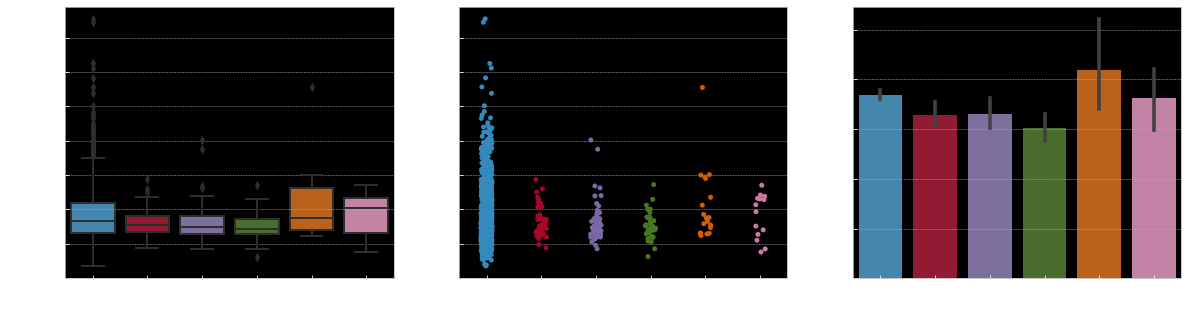

In [40]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType2", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]);

There seems as though there are a lot of houses with unfinished second basements, and this may cause the skew in terms og SalePrice's being relatively high for these...
There also looks to be only a few values for each of the other categories, with the highest average SalePrice coming from the second best category.


#### Type 2 finished square feet.


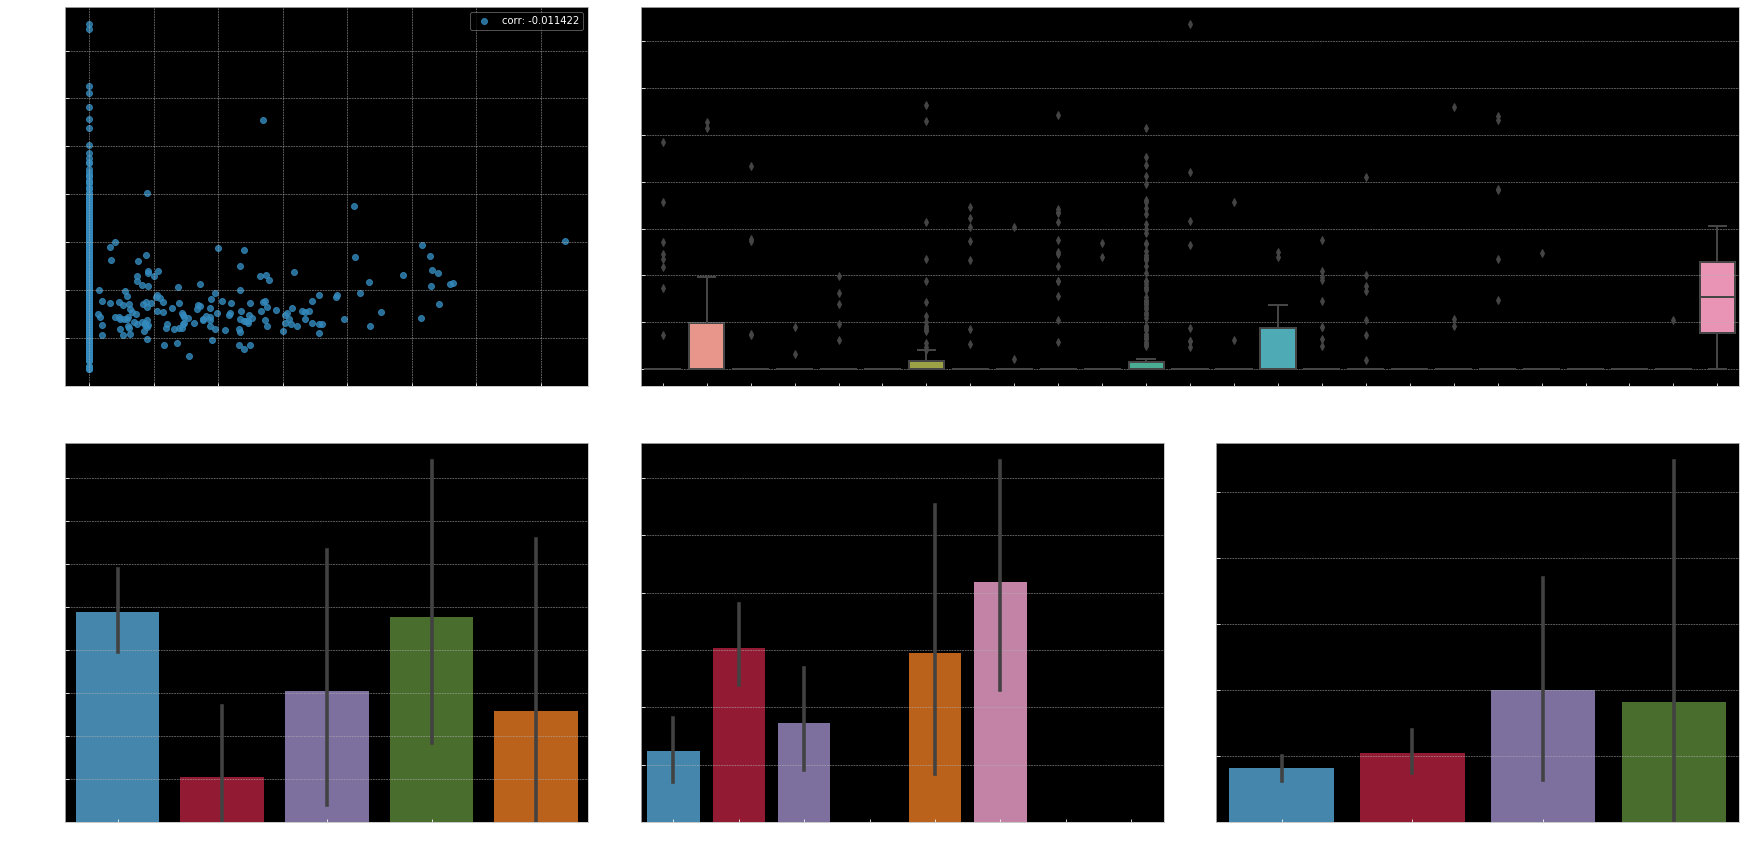

In [41]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF2'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF2'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF2", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF2", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF2", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF2", data=train);


There are a large number of data points with this feature = 0. Outside of this, there is no significant correlation with SalePrice and a large spread of values.


#### Unfinished square feet of basement area


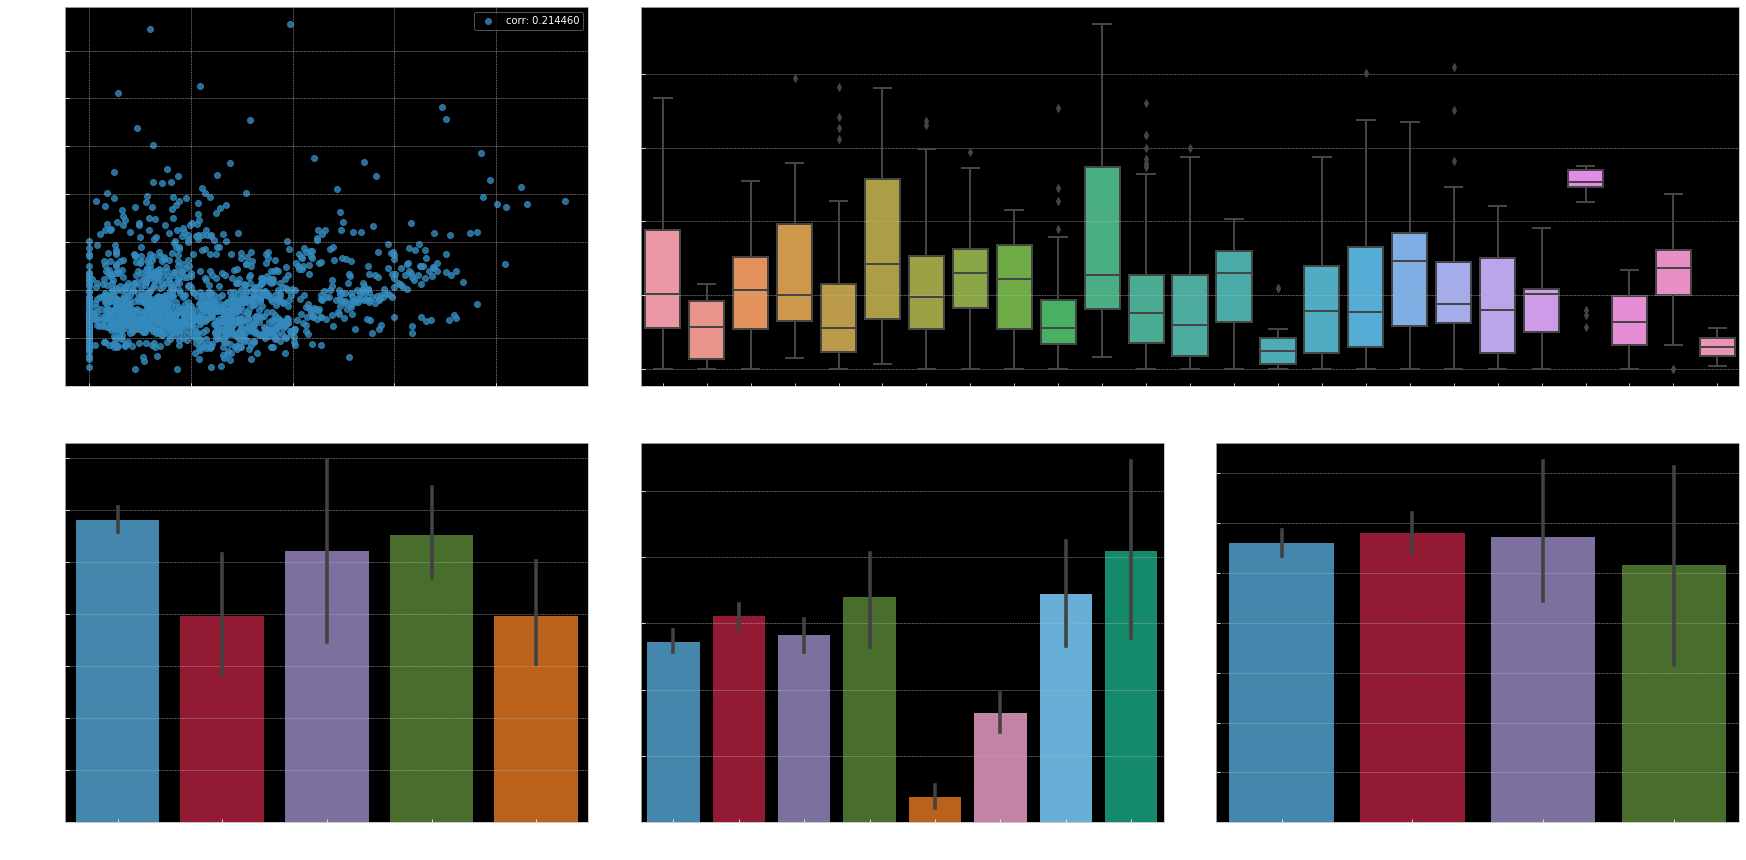

In [42]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtUnfSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtUnfSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtUnfSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtUnfSF", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtUnfSF", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtUnfSF", data=train);


This feature has a significant positive correlation with SalePrice, with a small proportion of data points having a value of 0. This tells me that most houses will have some amount of square feet unfinished within the basement, and this actually positively contributes towards SalePrice.
The amount of unfinished square feet also varies widely based on location and style.
Whereas the average unfinished square feet within the basement is fairly consistent across the different lot shapes.


#### Total square feet of basement area.


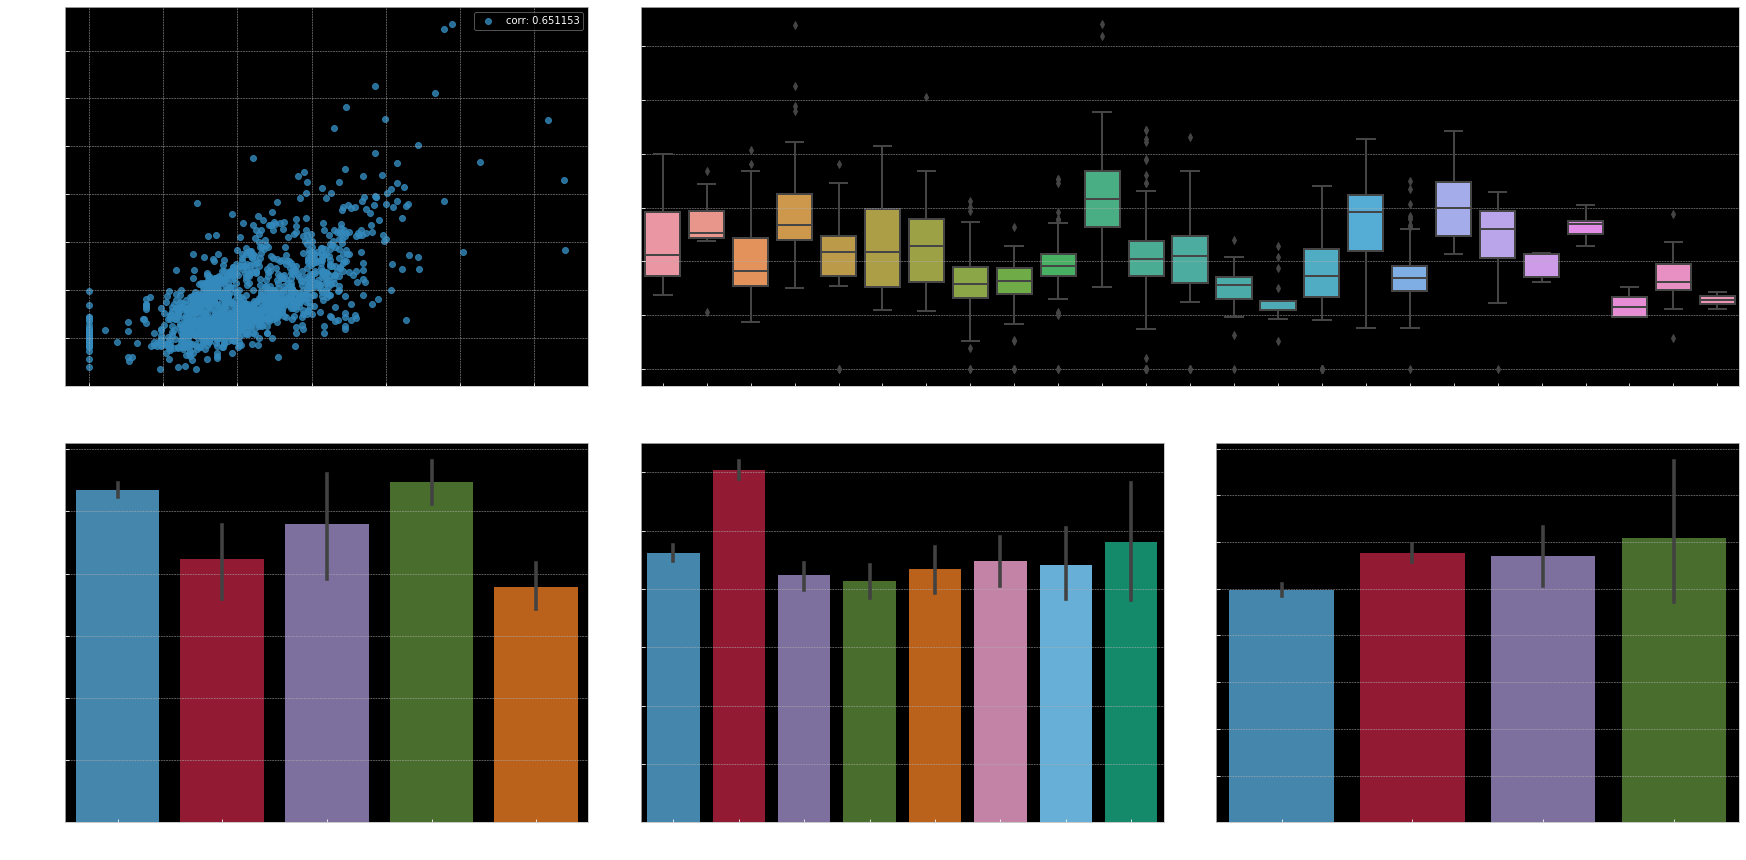

In [43]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalBsmtSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalBsmtSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalBsmtSF", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalBsmtSF", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalBsmtSF", data=train);


This will be a very important feature within my analysis, due to such a high correlation with Saleprice.
We can see that it varies widely based on location, however the average basement size has a lower variance based on type, style and lot shape.


#### First floor square feet.


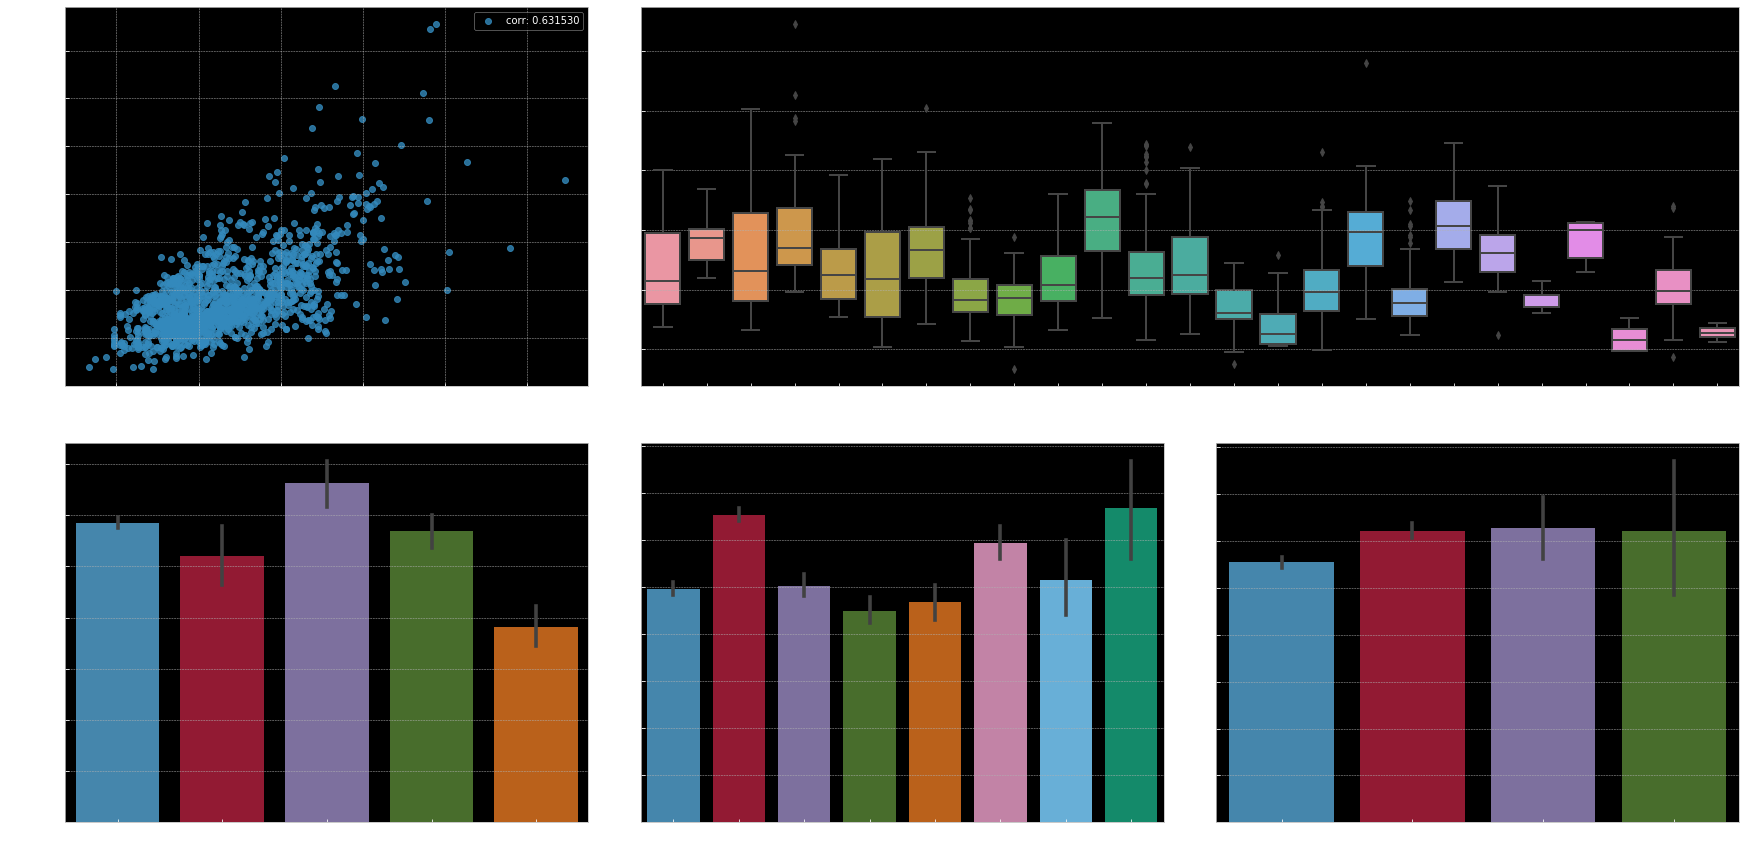

In [44]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['1stFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['1stFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="1stFlrSF", data=train )

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="1stFlrSF", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="1stFlrSF", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="1stFlrSF", data=train );

Clearly this shows a very high positive correlation with SalePrice, this will be an important feature during modeling.
Once again, this feature varies greatly across neighborhoods and the size of this feature varies across building types and styles.
This feature does not vary so much across the lot size.


#### Second floor square feet.


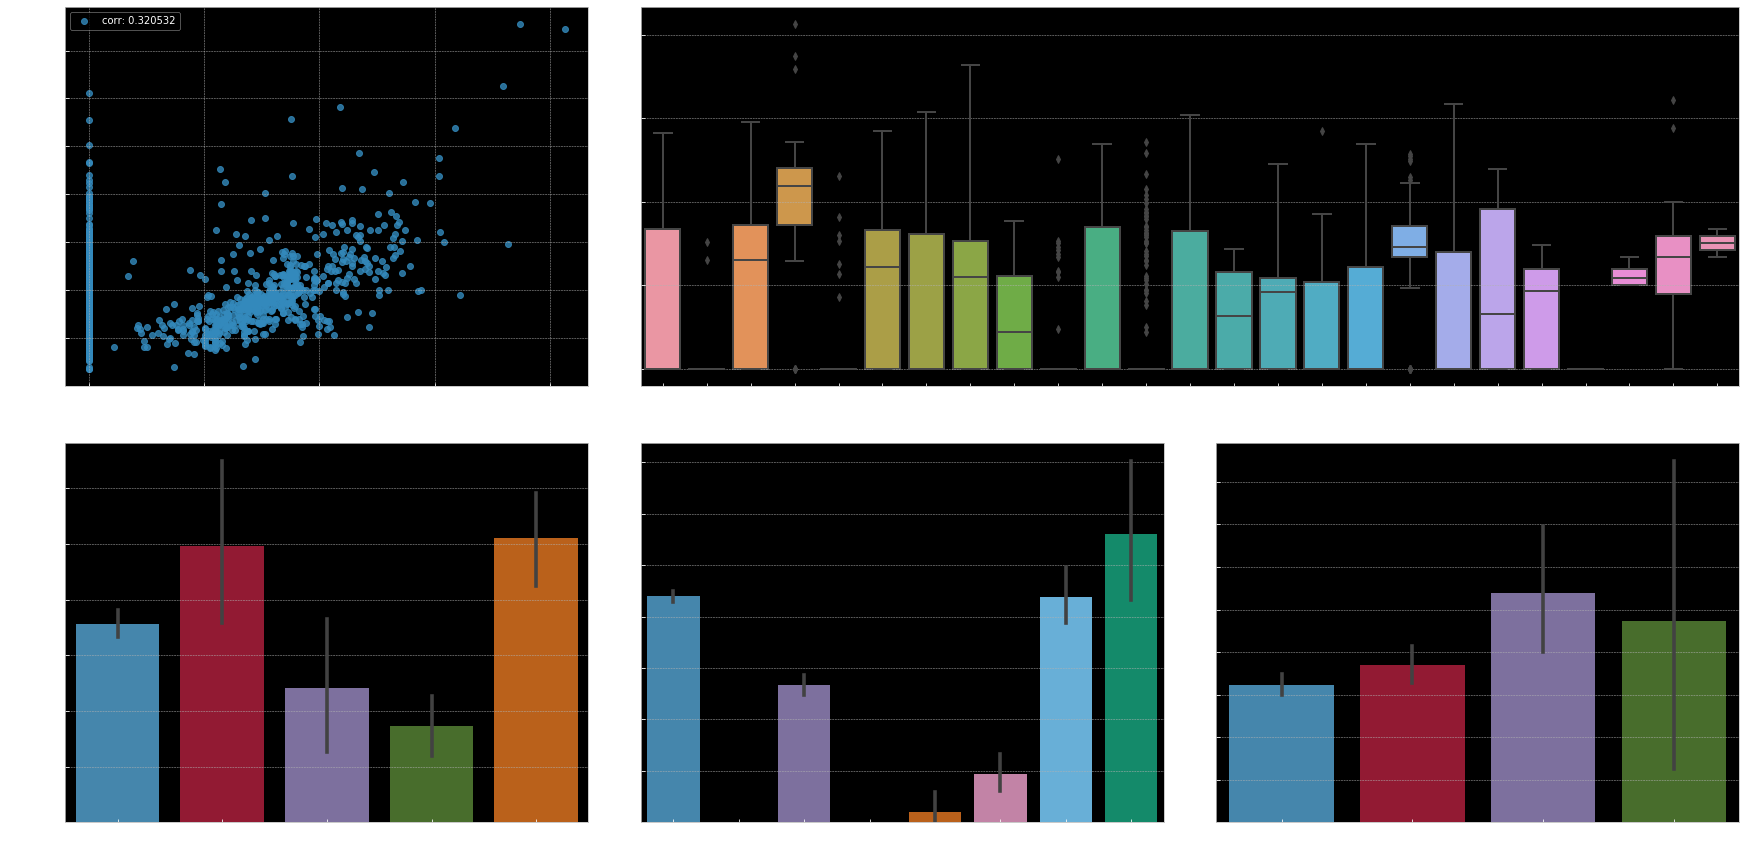

In [45]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['2ndFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['2ndFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="2ndFlrSF", data=train )

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="2ndFlrSF", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="2ndFlrSF", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="2ndFlrSF", data=train );

Interestingly we see a highly positively correlated relationship with SalePrice, however we also see a significant number of houses with value = 0.
This is explained with the other visuals, showing that some styles of houses perhaps do not have a second floor, hence cannot have a value for this feature - such as "1Story" houses.
We also see a high dependance and variation between neighborhoods, building types and lot sizes.
It is evident that all the variables related to "space" are important in this analysis. 

#### Bedrooms above grade (does not include basement bedrooms)


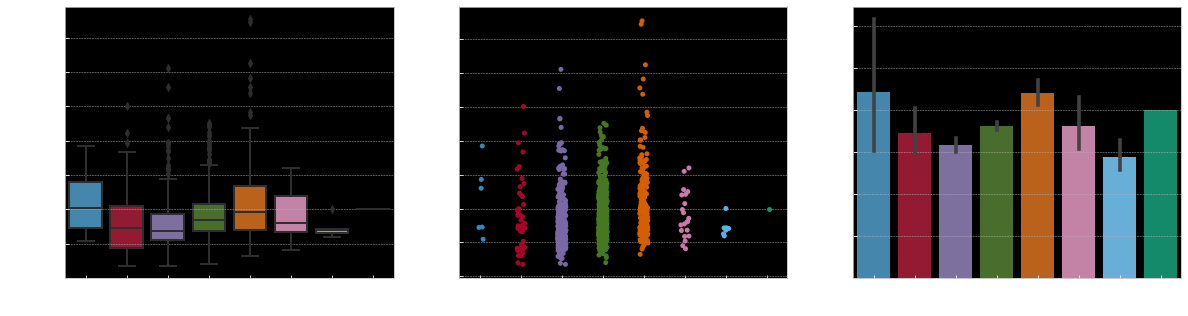

In [46]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="BedroomAbvGr", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="BedroomAbvGr", y="SalePrice", data=train );


We see a lot of houses with 2 3 and 4 bedrooms above ground, and a very low number of houses with 6 or above

#### Kitchens above grade.


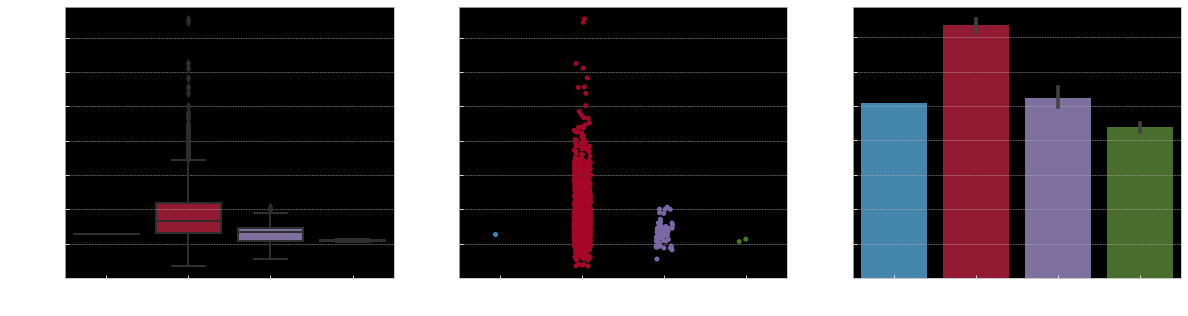

In [47]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenAbvGr", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenAbvGr", y="SalePrice", data=train );


Similarly to last previous feature, we see just a small number of houses with a large number of kitchens above grade. This shows that most houses have 1 kitchen above grade.


#### Kitchen quality.


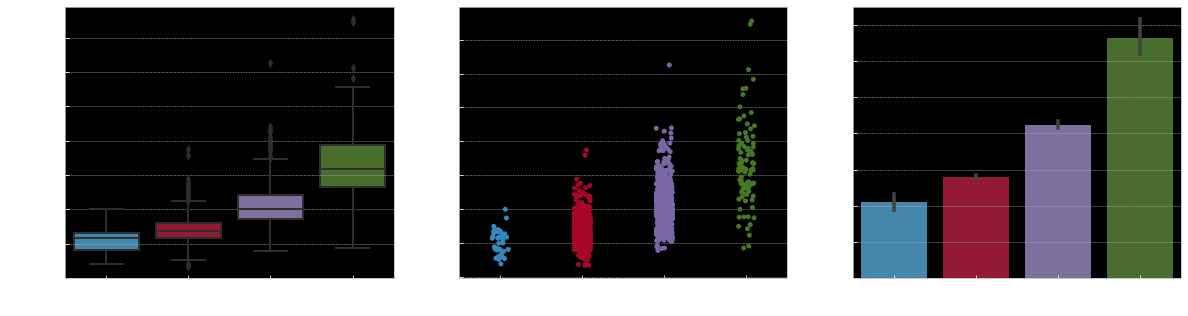

In [48]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"] )

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "TA", "Gd", "Ex"] );

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"] );


There is a clear positive correlation with the SalePrice and the quality of the kitchen.
There is one value for "Gd" that has an extremely high SalePrice however.


#### Total rooms above grade (does not include bathrooms)

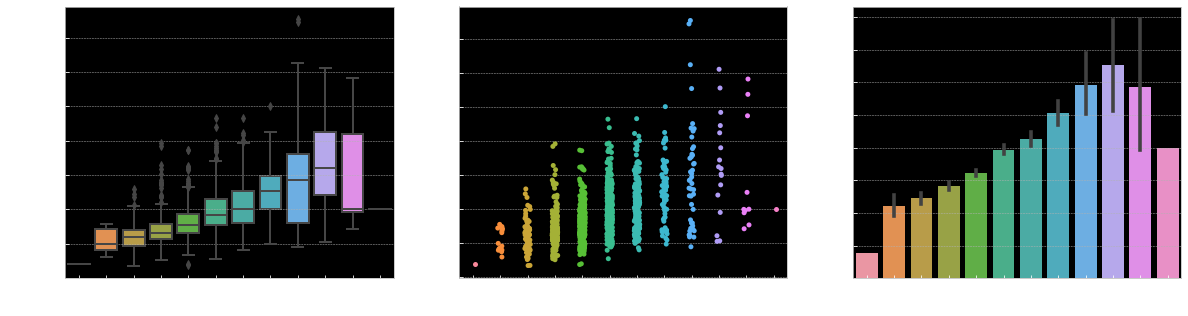

In [49]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="TotRmsAbvGrd", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train );


Generally we see a positive correlation, as the number of rooms increases, so does the SalePrice.
However due to low frequency, we do see some unreliable results for the very large and small values for this feature.


#### Number of fireplaces.


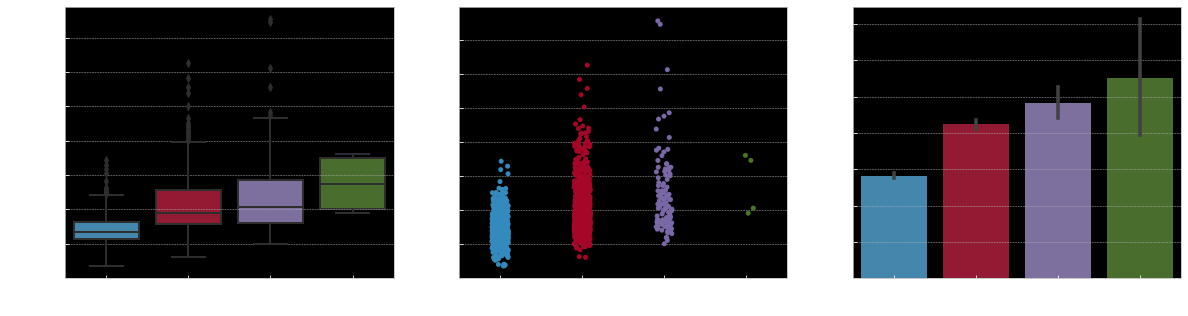

In [50]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fireplaces", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fireplaces", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Fireplaces", y="SalePrice", data=train);


Once again we have a positive correlation with SalePrice, with most houses having just 1 or 0 fireplaces.

#### Fireplace quality.


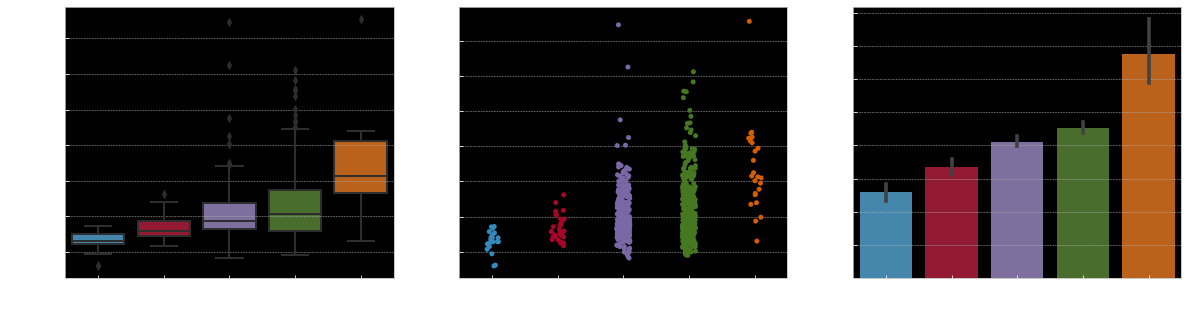

In [51]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"] )

plt.subplot(1, 3, 2)
sns.stripplot(x="FireplaceQu", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"] );

plt.subplot(1, 3, 3)
sns.barplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"] );


We also see a positive correlation and the fireplace quality increases. Most houses have either "TA" or "Gd" quality fireplaces.

#### Above grade ground living area in square feet.


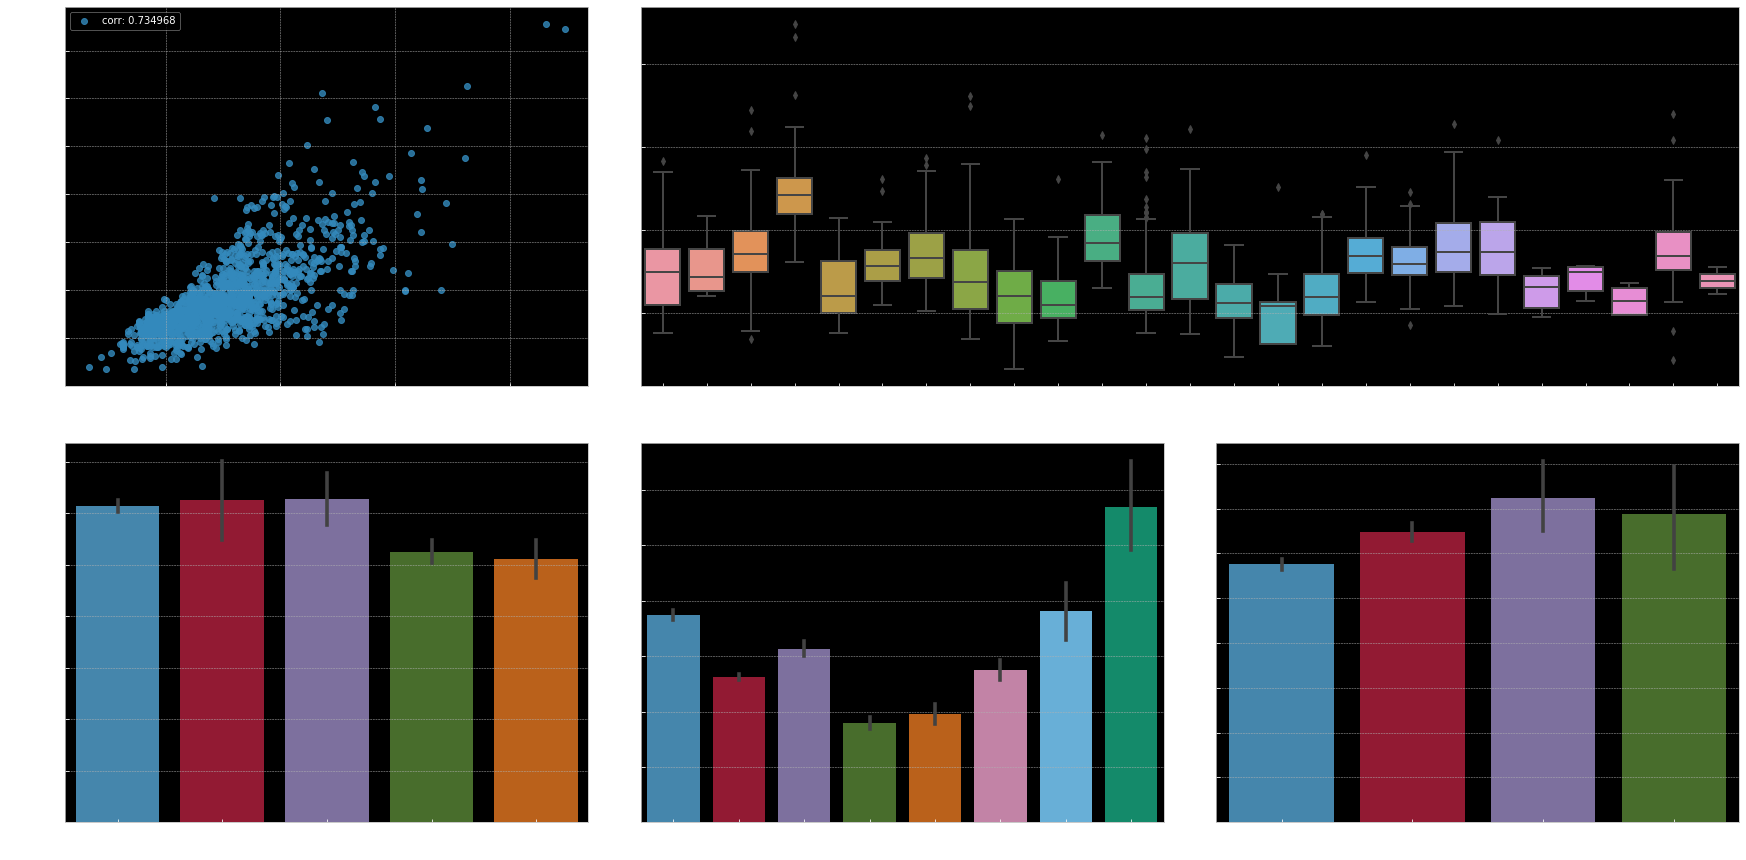

In [52]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GrLivArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GrLivArea", data=train )

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GrLivArea", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GrLivArea", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GrLivArea", data=train );


We see a very high positive correlation with SalePrice.
We also see the values varying very highly between styles of houses and neigborhood.


#### Identifies the type of dwelling involved in the sale.


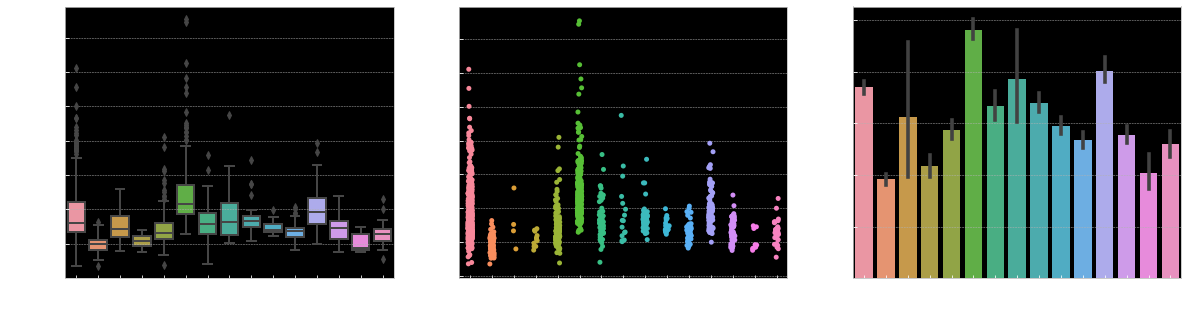

In [53]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSSubClass", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="MSSubClass", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="MSSubClass", y="SalePrice", data=train );


Each of these classes represents a very different style of building, as shown in the data description. Hence, we can see large variance between classes with SalePrice.
This is a numeric feature, but it should actually be categorical

#### Type of dwelling.


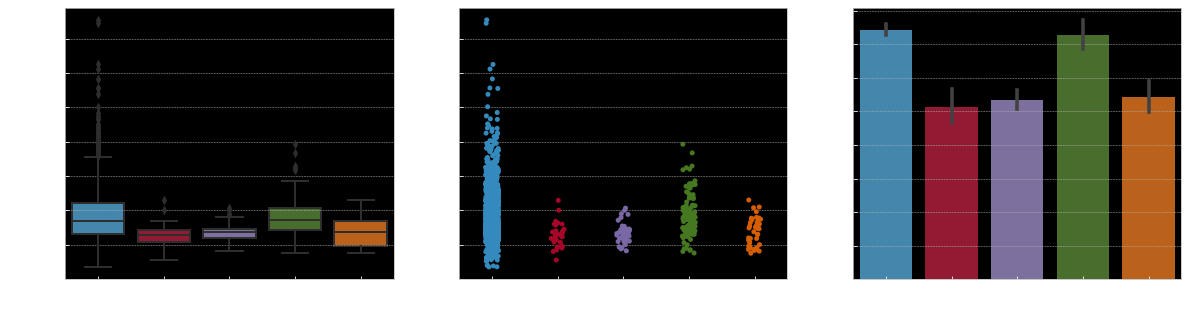

In [54]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BldgType", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="BldgType", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="BldgType", y="SalePrice", data=train );


The different categories exhibit a range of average SalePrice's. The class with the most observations is "1Fam".
We can also see that the variance within classes is quite tight, with only a few extreme values in each case.

#### Style of dwelling.

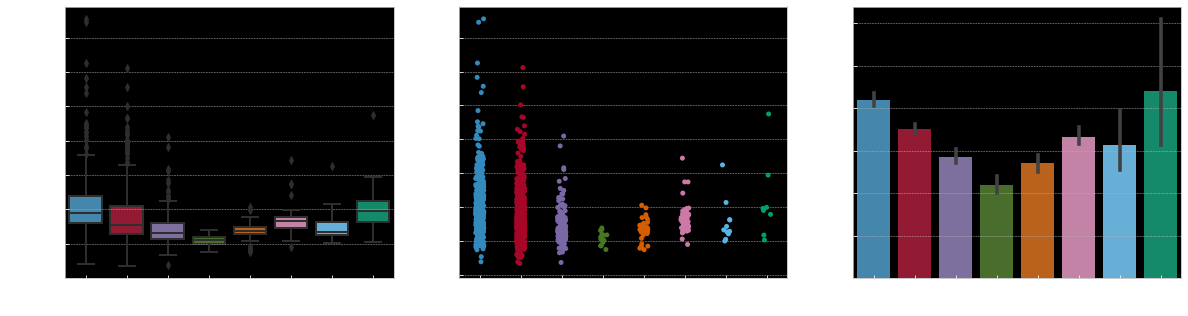

In [55]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HouseStyle", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="HouseStyle", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="HouseStyle", y="SalePrice", data=train );


Here we see quite a few extreme values across the categories and a large weighting of observations towards the integer story houses.
Although the highest average SalePrice comes from "2.5Fin", this has a very high standard deviation and therefore more reliably, the "2Story" houses are also very highly priced on average.


#### Rates the overall material and finish of the house.


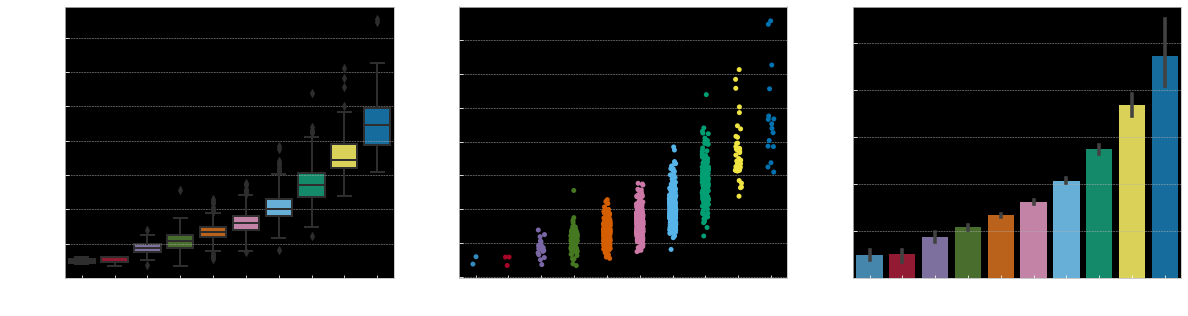

In [56]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallQual", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallQual", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="OverallQual", y="SalePrice", data=train );


This feature although being numeric is actually categoric and ordinal, as the value increases so does the SalePrice. Hence, I will keep it as a numeric feature.
We see here a nice positive correlation with the increase in OverallQual and the SalePrice, as you'd expect.


#### Rates the overall condition of the house.

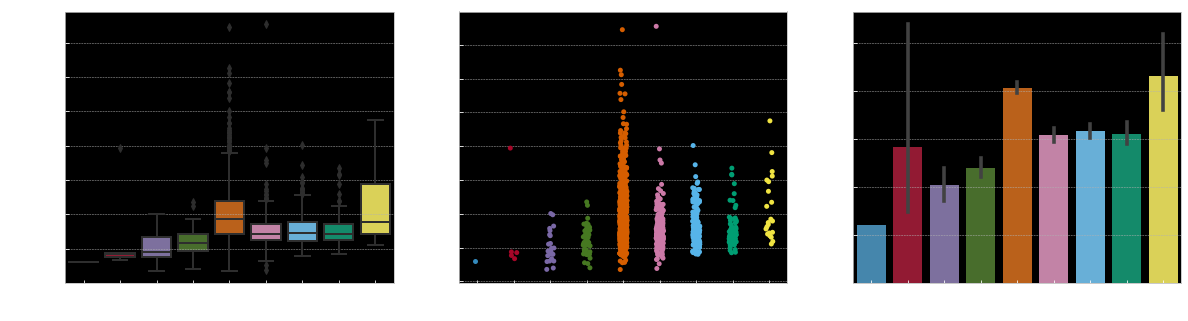

In [57]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallCond", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallCond", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="OverallCond", y="SalePrice", data=train );


Interestingly, we see here that it does follow a positive correlation with SalePrice, however we see a peak at a value of 5, along with a high number of observations at this value.
The highest average SalePrice actually comes from a value of 5 as opposed to 10, which may be a reasonable assumption

#### Remodel date (same as construction date if no remodeling or additions).


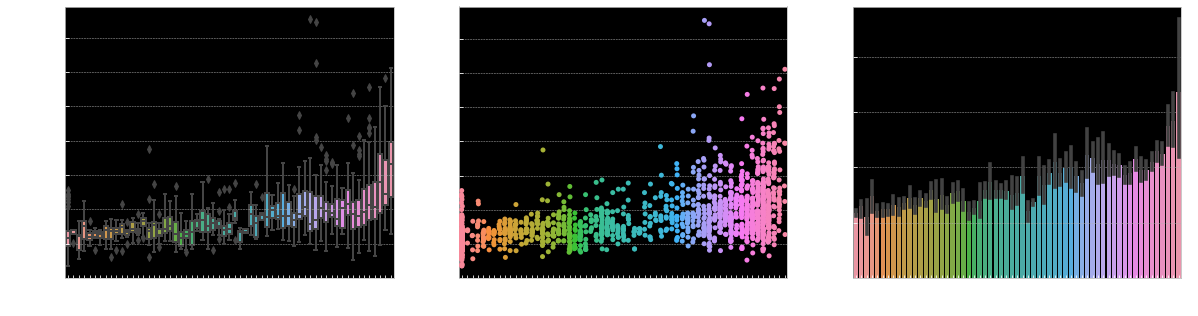

In [58]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="YearRemodAdd", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="YearRemodAdd", y="SalePrice", data=train );


Here we can see that the newer the remodelling of a house, the higher the SalePrice.
From the data description, I believe that creating a new feature describing the difference in number of years between remodeling and construction may be a good choice.


#### Original construction date.

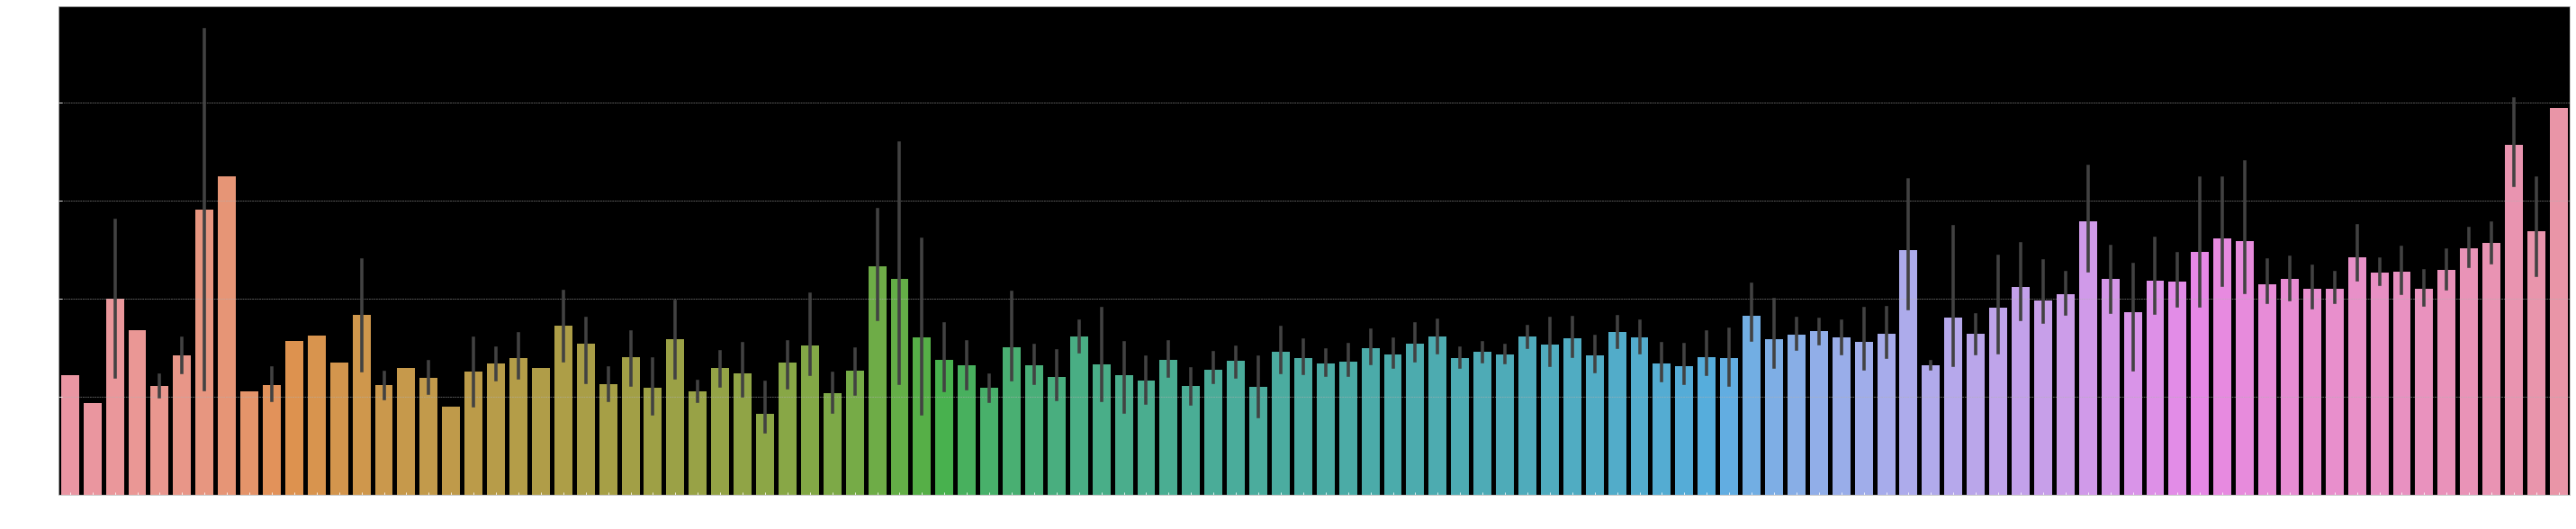

In [59]:
plt.subplots(figsize =(50, 10))

sns.barplot(x="YearBuilt", y="SalePrice", data=train);


Here we can see a fairly consistent upward trend for the SalePrice as houses are more modern.


#### Type of foundation.


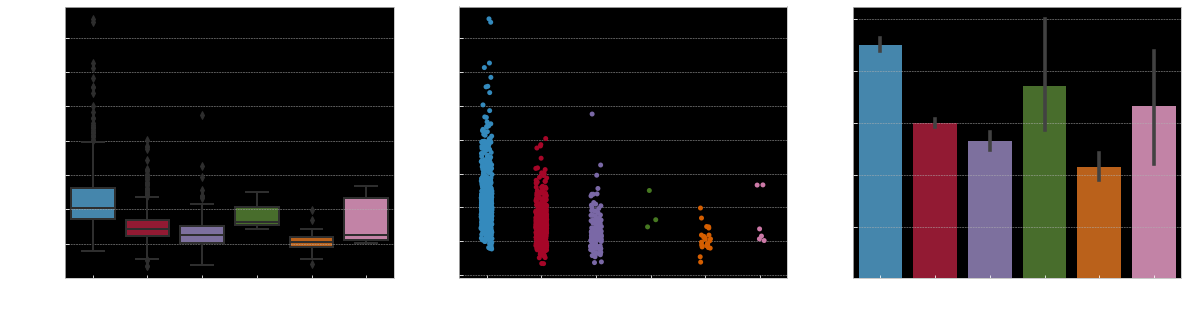

In [60]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Foundation", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="Foundation", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="Foundation", y="SalePrice", data=train );


We have 3 classes with high frequency, however we have 3 of low frequency.
Due to the large difference in median and mean SalePrice's across the 3 lower frequent classes, I am not going to cluster these together

#### Home functionality.

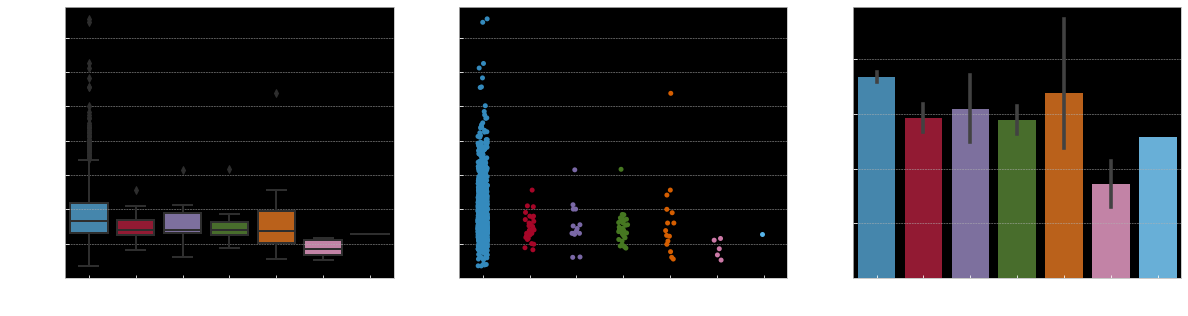

In [61]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Functional", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="Functional", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="Functional", y="SalePrice", data=train );


This categorical feature shows that most houses have "Typ" functionality, and looking at the data description leads me to believe that there is an order within these categories, "Typ" being of the highest order.


## Exterior

#### Type of roof.


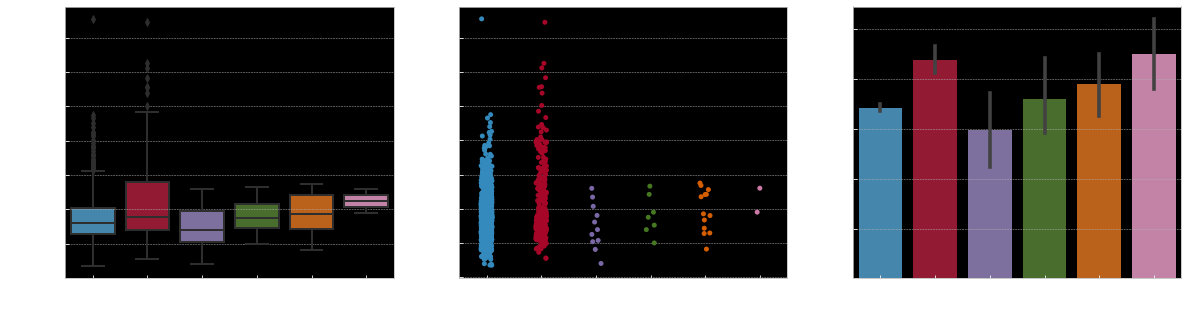

In [62]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofStyle", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofStyle", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="RoofStyle", y="SalePrice", data=train );


This feature has two highly frequent categories but the values of SalePrice differ between each.


#### Roof material.

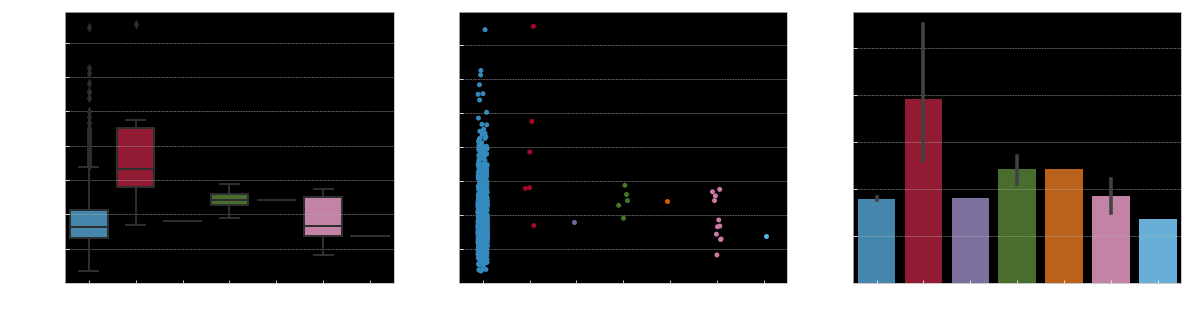

In [63]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofMatl", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofMatl", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="RoofMatl", y="SalePrice", data=train );


Interestingly, there are very few observations in the training data for several classes. However, these will be dropped during feature reduction if they turn out to be insignificant.

#### Exterior covering on house.


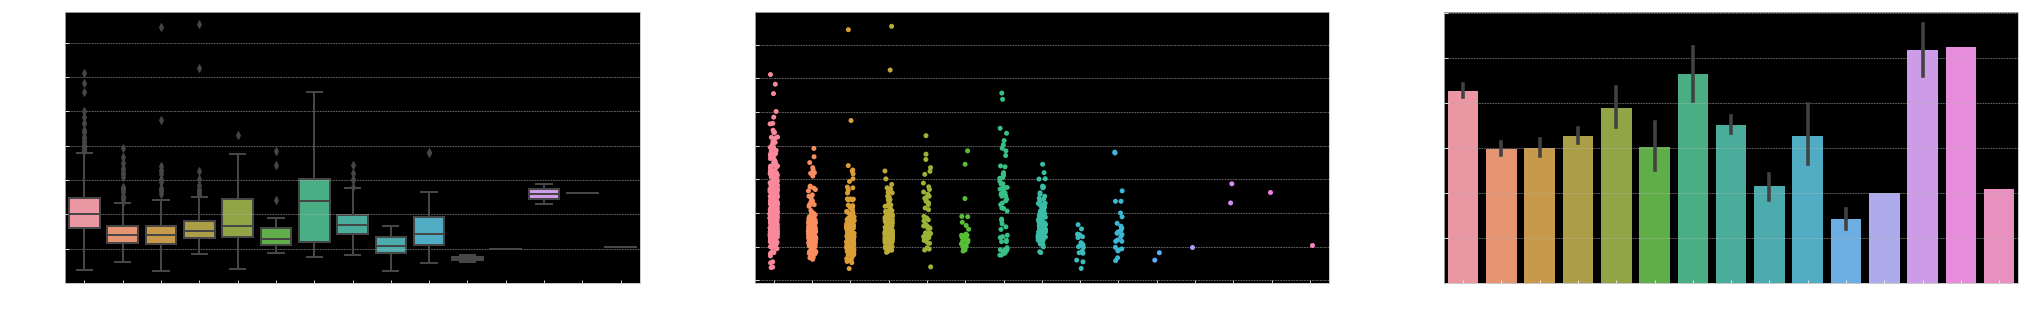

In [64]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior1st", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior1st", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior1st", y="SalePrice", data=train );


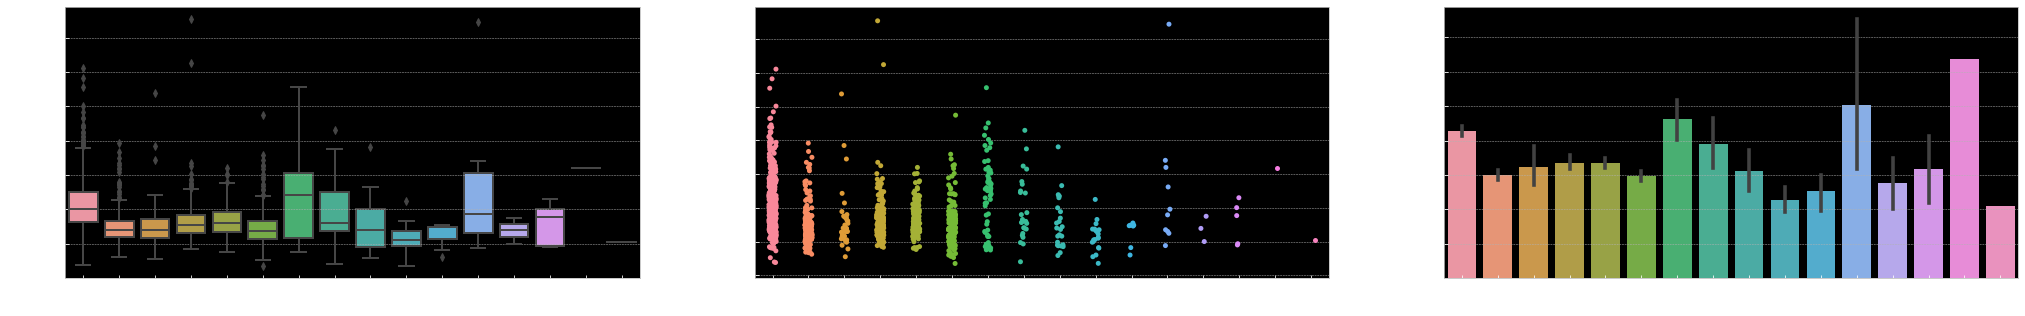

In [65]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior2nd", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior2nd", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior2nd", y="SalePrice", data=train );


Looking at these 2 features together, we can see that they exhibit very similar behaviours against SalePrice. This tells me that they are very closely related.


#### Masonry veneer type.


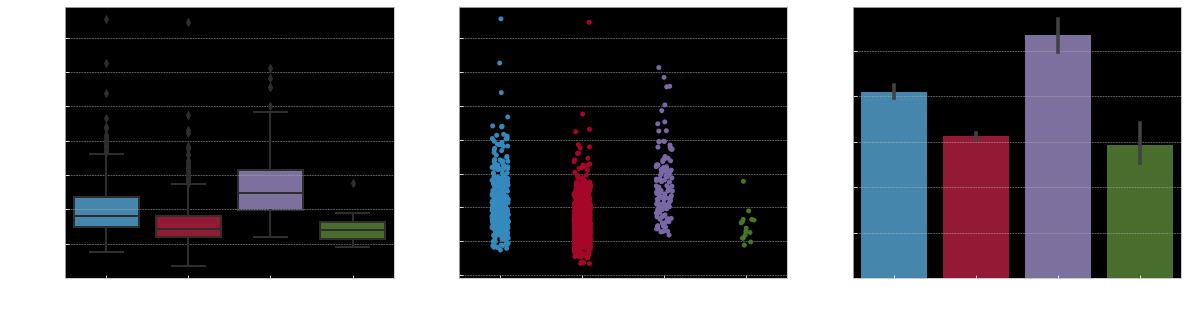

In [66]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MasVnrType", y="SalePrice", data=train );

plt.subplot(1, 3, 2)
sns.stripplot(x="MasVnrType", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="MasVnrType", y="SalePrice", data=train );


Each class has quite a unique range of values for SalePrice, the only class that stands out is "BrkCmn", which has a low frequency.
Clearly "Stone" demands the highest SalePrice on average, although there are some extreme values within "BrkFace".


#### Masonry veneer area in square feet.


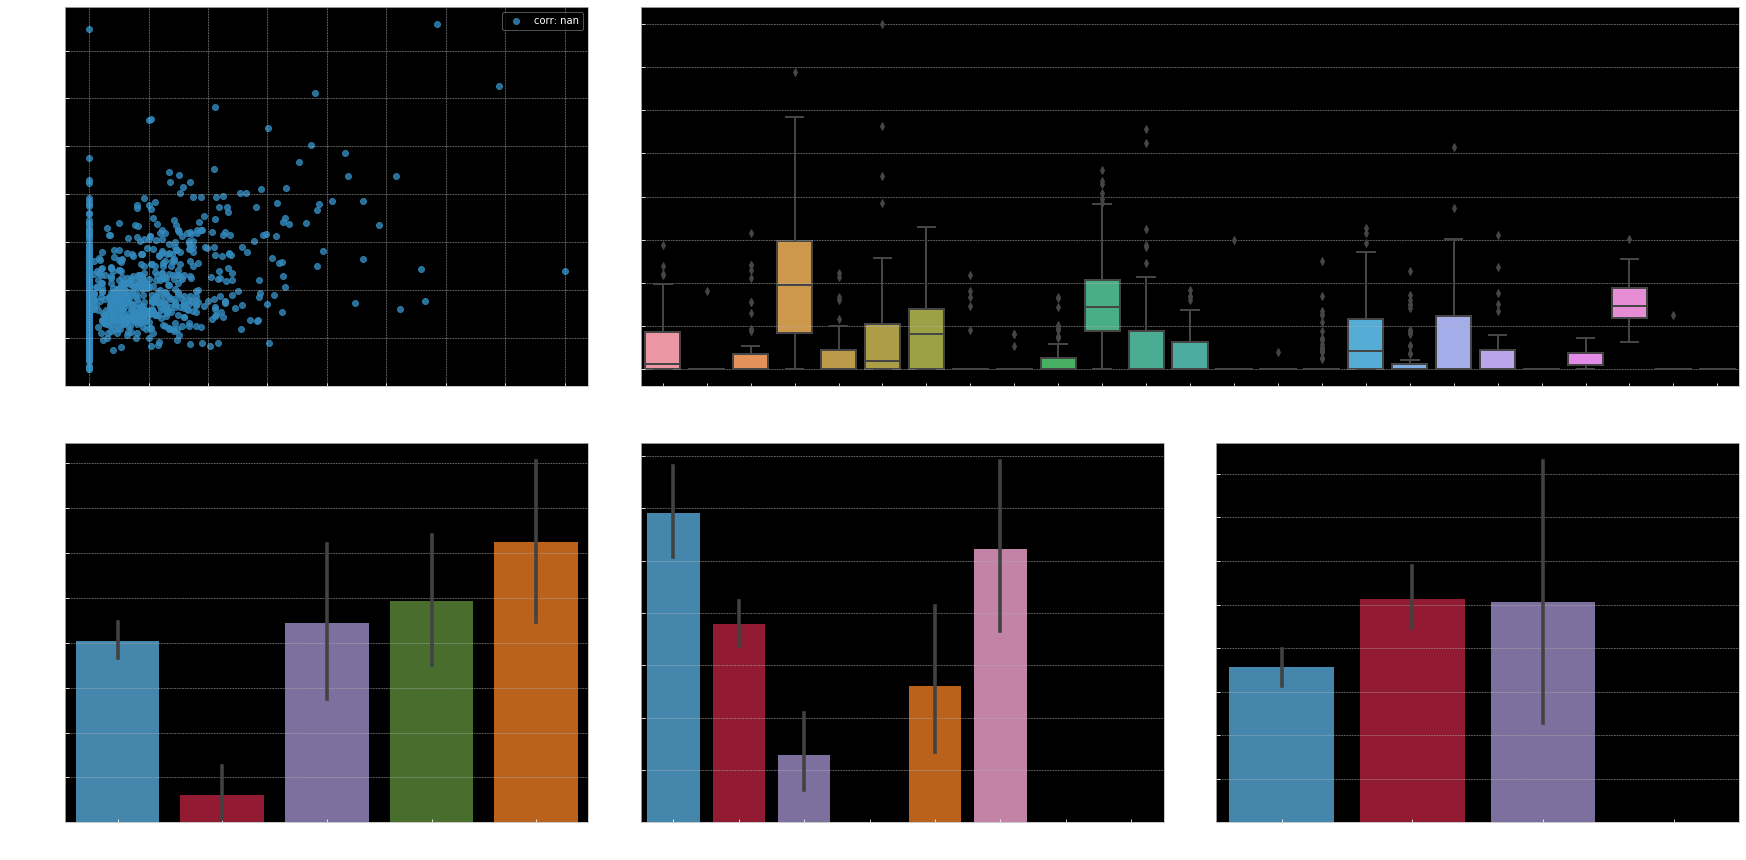

In [67]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['MasVnrArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['MasVnrArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="MasVnrArea", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="MasVnrArea", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="MasVnrArea", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="MasVnrArea", data=train );


From this we can see that this feature has negligible correlation with SalePrice, and the values for this feature vary widely based on house type, style and size.
Since this feature is insignificant in regards to SalePrice, and it also correlates highly with "MasVnrType" (if "MasVnrType = "None" then it has to be equal to 0), I will drop this feature.


#### Evaluates the quality of the material on the exterior.


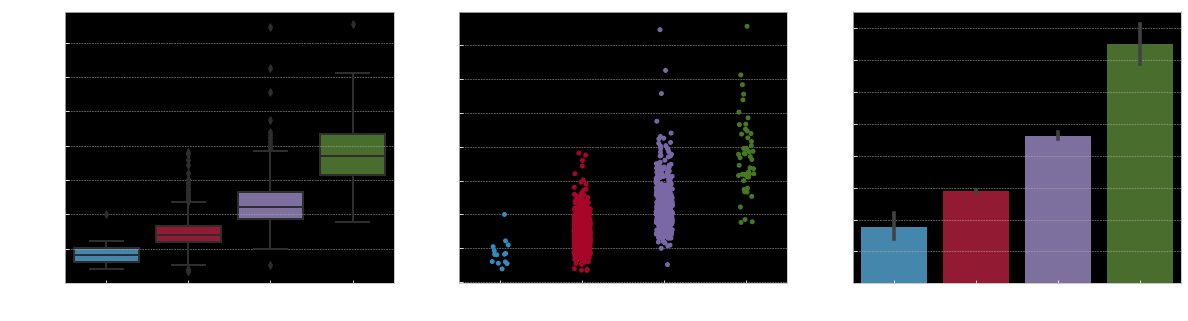

In [68]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'] )

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa','TA','Gd', 'Ex'] );

plt.subplot(1, 3, 3)
sns.barplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'] );


We can see here that this feature shows a clear order and has a positive correlation with SalePrice. As the quality increases, so does the SalePrice.
We see the largest number of observations within the two middle classes, and the lowest observations within the lowest class.


#### Evaluates the present condition of the material on the exterior.


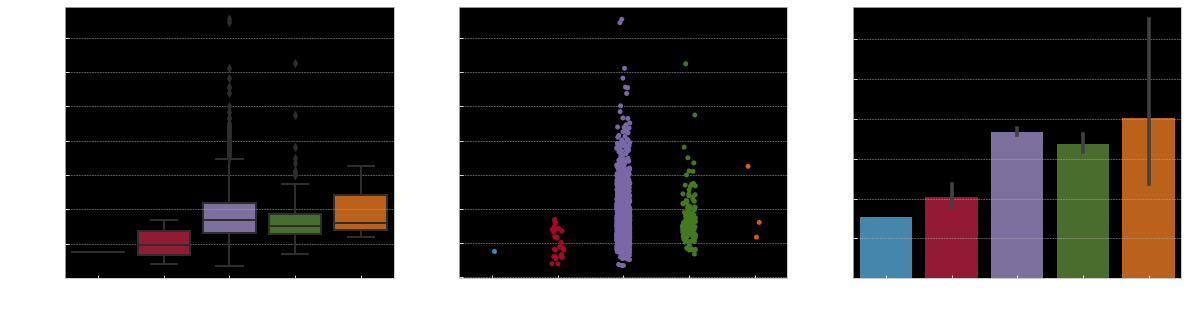

In [69]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'] )

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po','Fa','TA','Gd', 'Ex'] );

plt.subplot(1, 3, 3)
sns.barplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'] );


Interestingly we see the largest values of SalePrice for the second and third best classes. This is perhaps because of the large frequency of values within these classes, whereas we only see 3 observations within "Ex" from the training data.


#### Garage location.


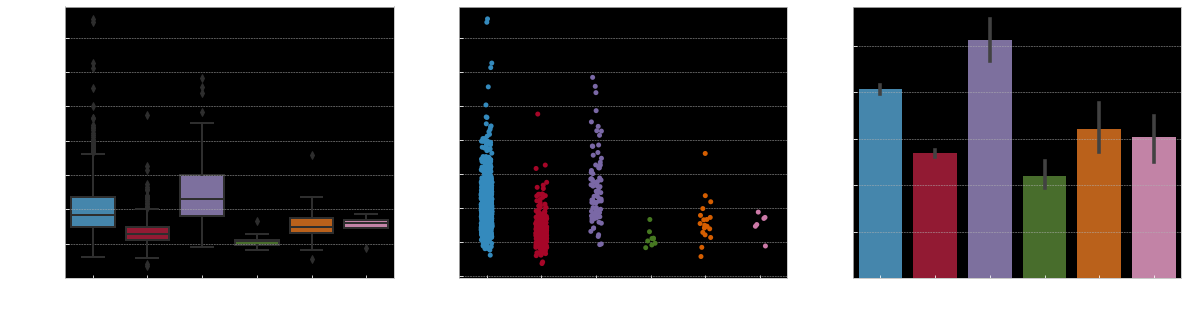

In [70]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageType", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageType", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="GarageType", y="SalePrice", data=train );

Here we see "BuiltIn" and "Attched" having the 2 highest average SalePrices, with only a few extreme values within each class

#### Year garage was built.


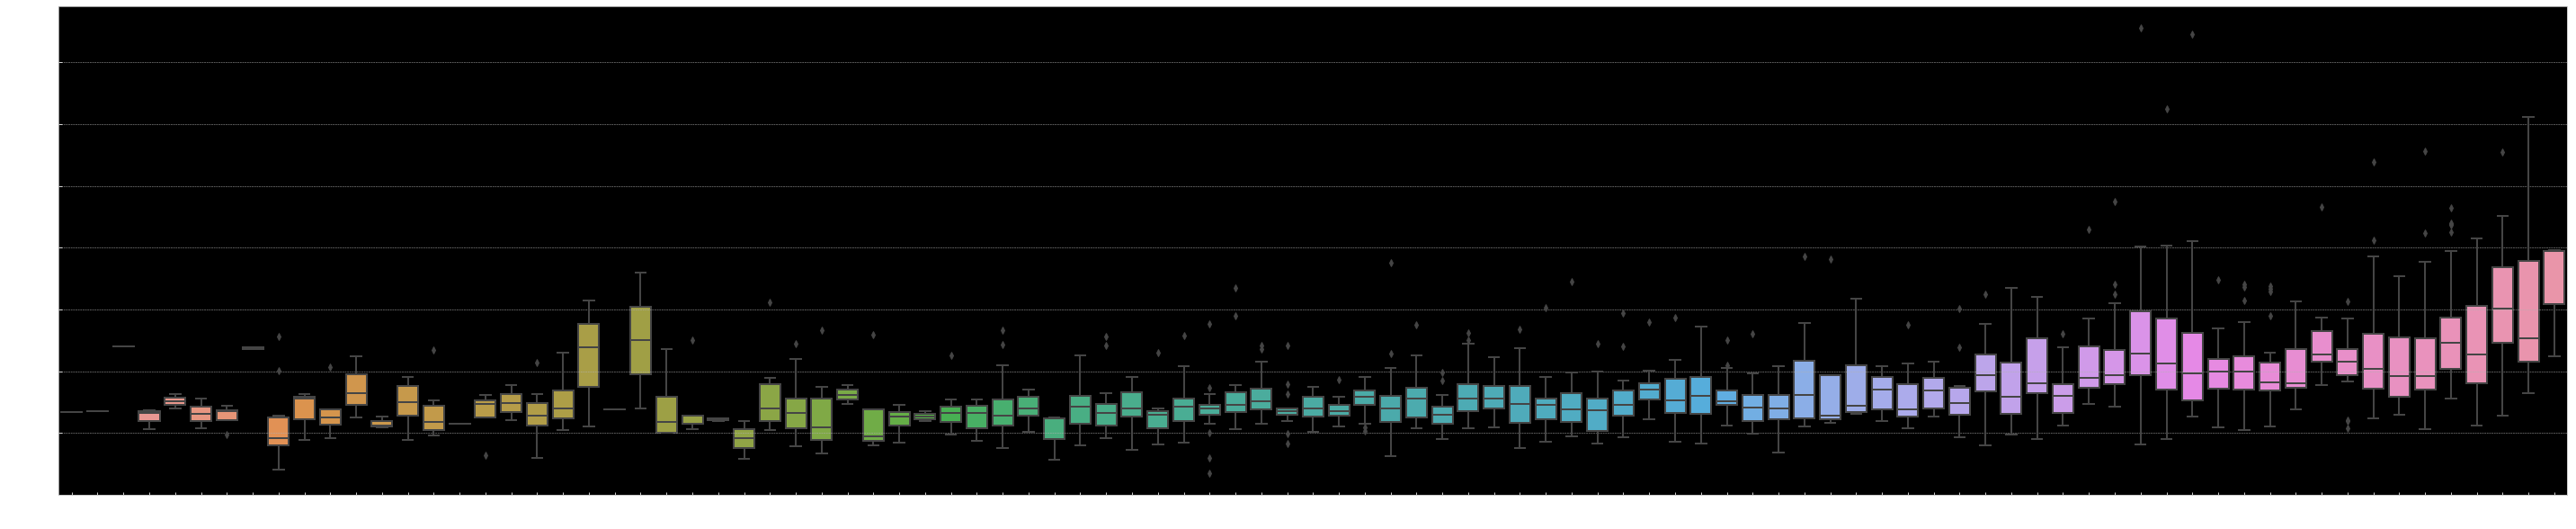

In [71]:
plt.subplots(figsize =(50, 10))

sns.boxplot(x="GarageYrBlt", y="SalePrice", data=train );


We can see a slight upward trend as the garage building year becomes more modern.


#### Interior finish of the garage.

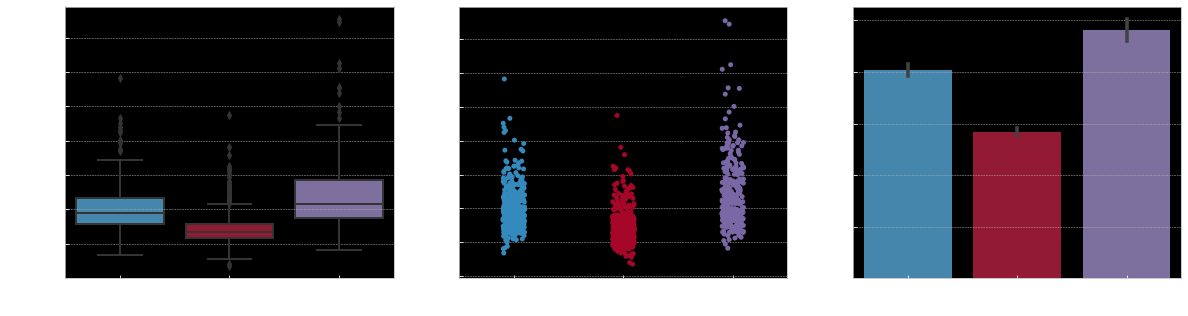

In [72]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageFinish", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageFinish", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="GarageFinish", y="SalePrice", data=train );


Here we see a nice split between the 3 classes, with "Fin" producing the highest SalePrice's on average.


#### Size of the garage in car capacity.


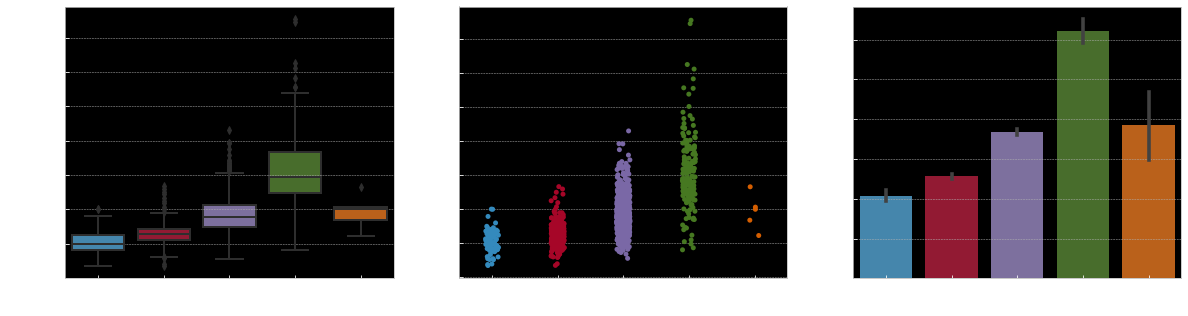

In [73]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCars", y="SalePrice", data=train )

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCars", y="SalePrice", data=train, size = 5, jitter = True );

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCars", y="SalePrice", data=train );


We generally see a positive correlation with an increasing garage car capacity. However, we see a slight dip for 4 cars I believe due to the low frequency of houses with a 4 car garage.

#### Size of the garage in square feet.


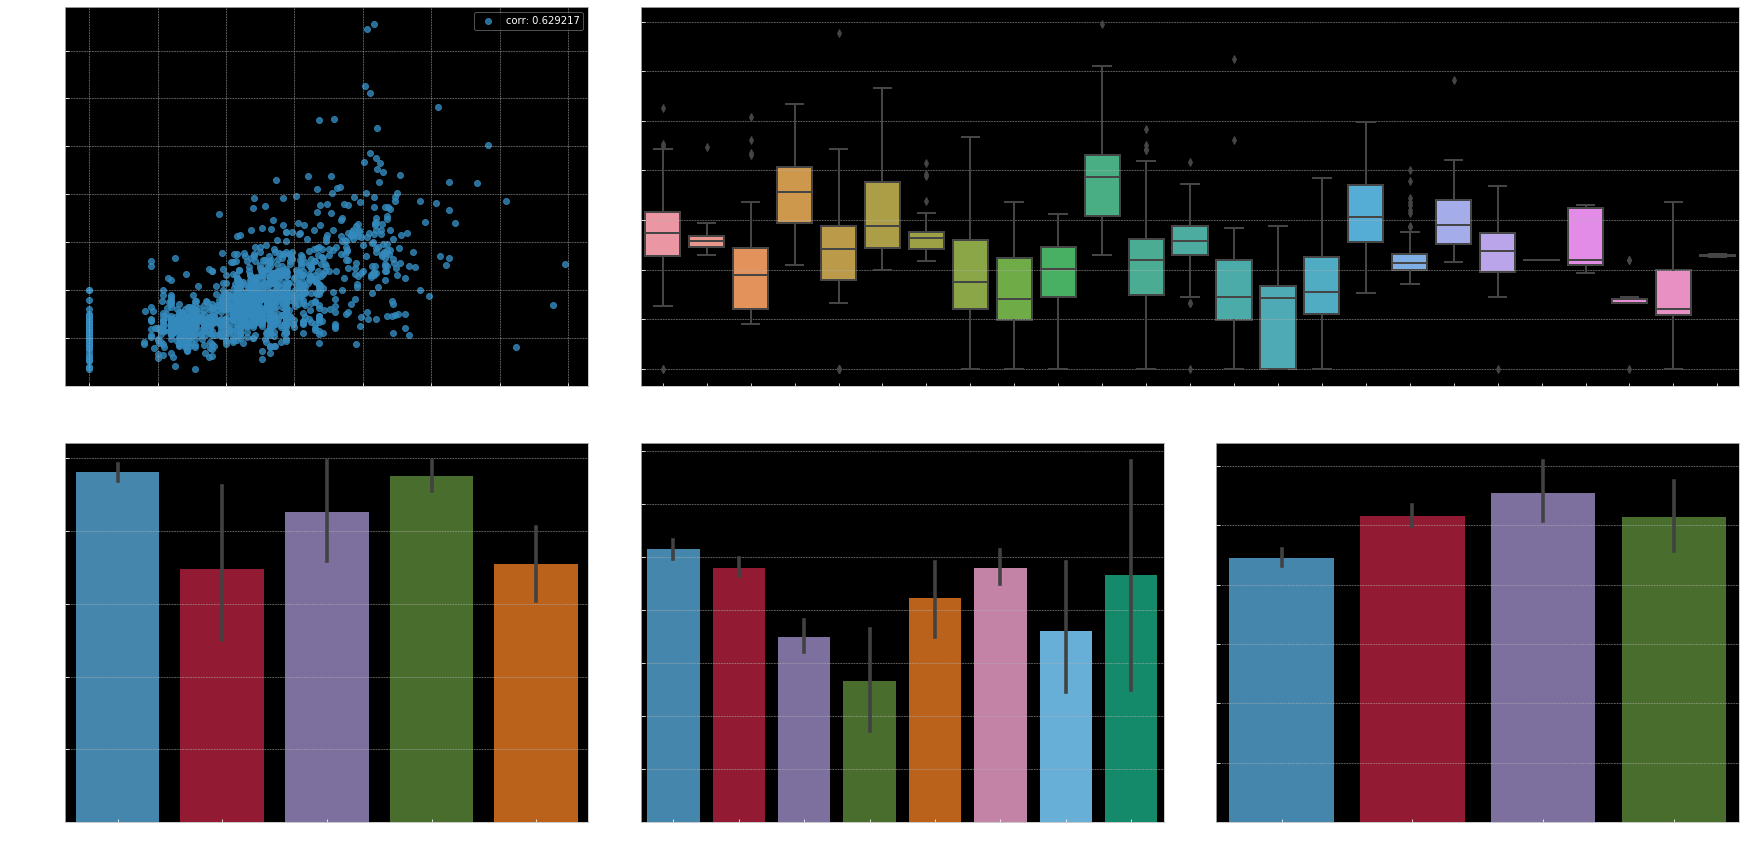

In [74]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GarageArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GarageArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GarageArea", data=train )

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GarageArea", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GarageArea", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GarageArea", data=train );


This has an extremely high positive correlation with SalePrice, and it is highly dependant on Neighborhood, building type and style of the house.
This could be an important feature in the analysis

#### Garage quality.


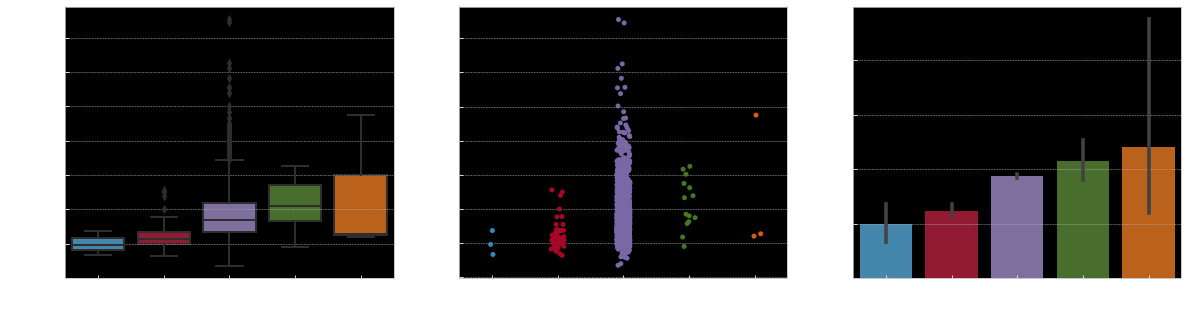

In [75]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"] )

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageQual", y="SalePrice", data=train, size = 5, jitter = True,\
              order=["Po", "Fa", "TA", "Gd", "Ex"] );

plt.subplot(1, 3, 3)
sns.barplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"] );


We see a lot of homes having "TA" quality garages, with very few homes having high quality and low quality ones

#### Garage condition.

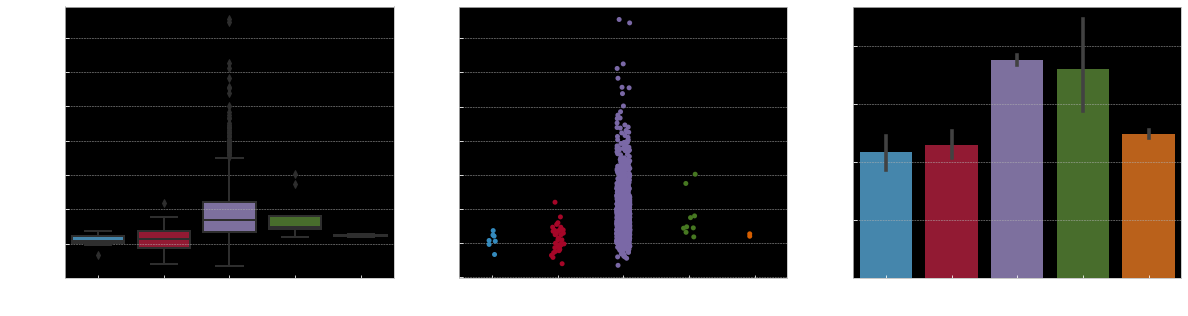

In [76]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"])

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCond", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"]);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"]);


We see a fairly similar pattern here with the previous feature. We see a slight positive correlation and then a dip, I believe due to the low number of houses that have "Ex" or "Gd" garage conditions.


#### Wood deck area in SF.

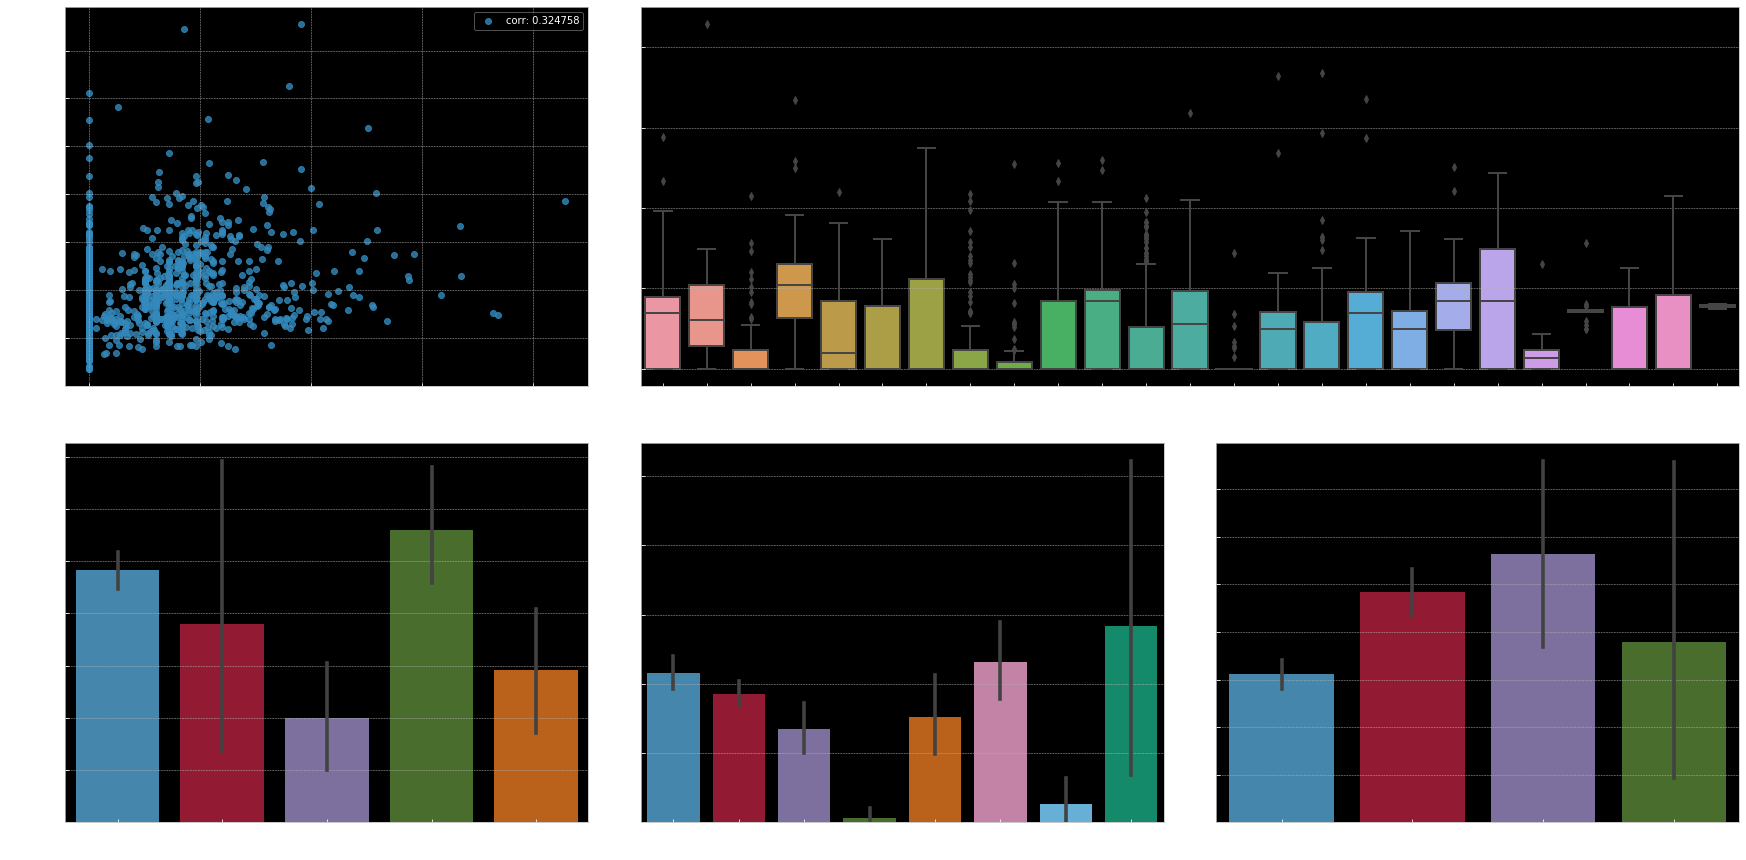

In [77]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['WoodDeckSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['WoodDeckSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="WoodDeckSF", data=train);


This feature has a high positive correlation with SalePrice.
We can also see that it varies widely with location, building type, style and size of the lot.


#### OpenPorchSF, EnclosedPorch, 3SsnPorch & ScreenPorch

I will sum these features together to create a total porch in square feet feature.

In [78]:
data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch']\
                        + data['3SsnPorch'] + data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch']\
                        + train['3SsnPorch'] + train['ScreenPorch']

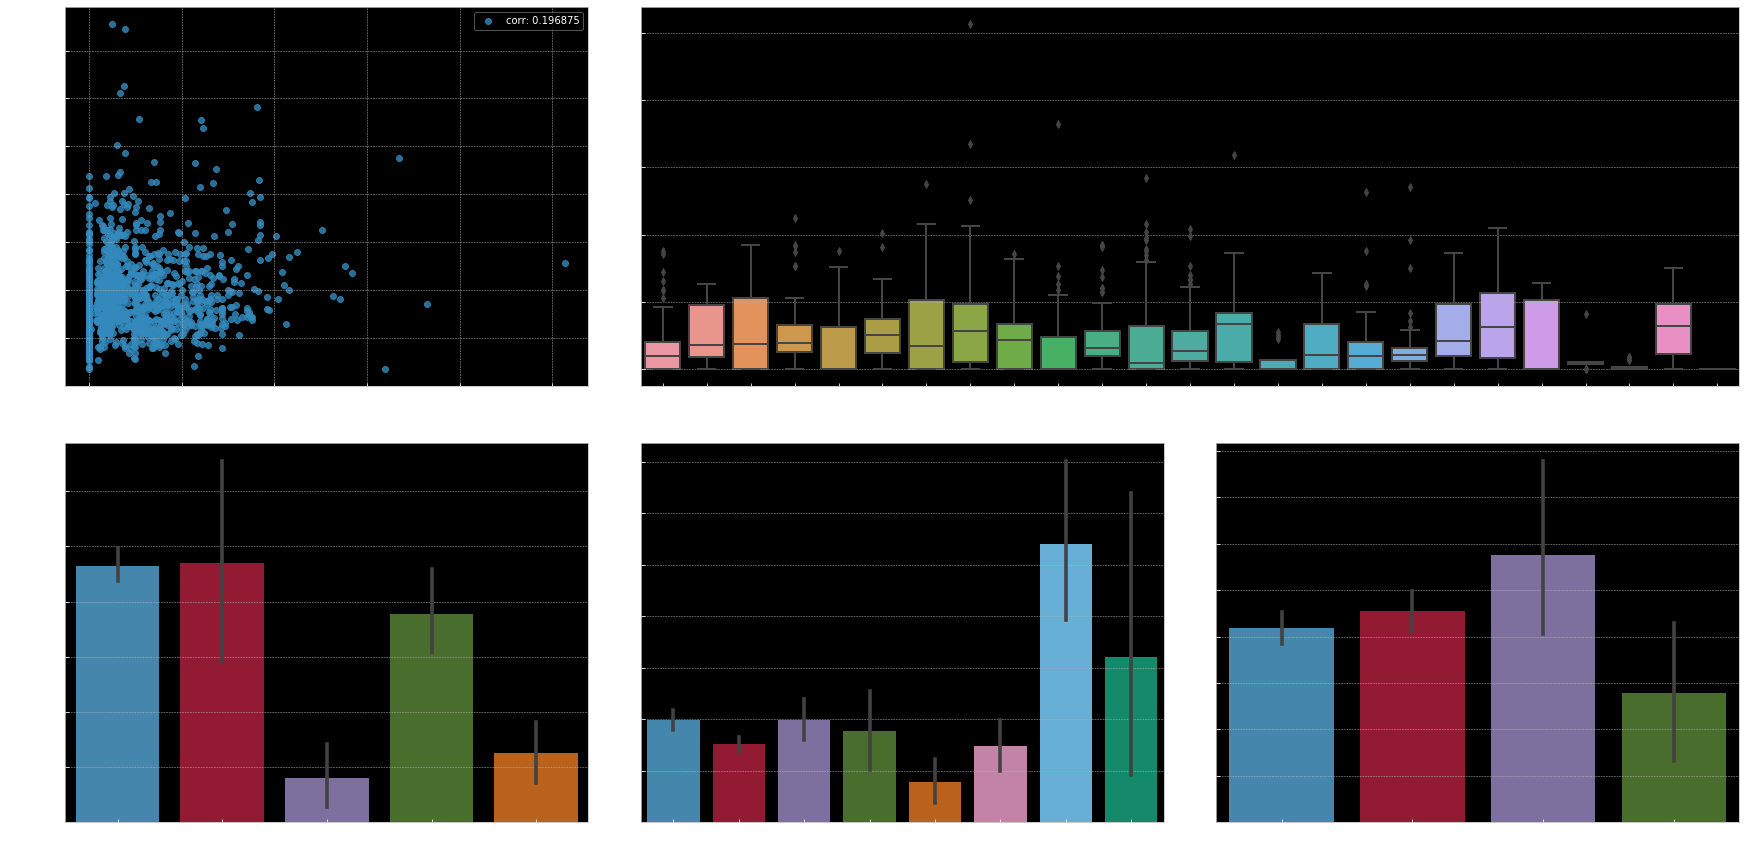

In [79]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalPorchSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalPorchSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalPorchSF", data=train )

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalPorchSF", data=train )

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalPorchSF", data=train )

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalPorchSF", data=train );

We can see a high number of data points having a value of 0 here once again.
Apart from this, we see a high positive correlation with SalePrice showing that this may be an influential factor for analysis.
Finally, we see that this value ranges widely based on location, building type, style and lot.

#### Pool area in square feet.

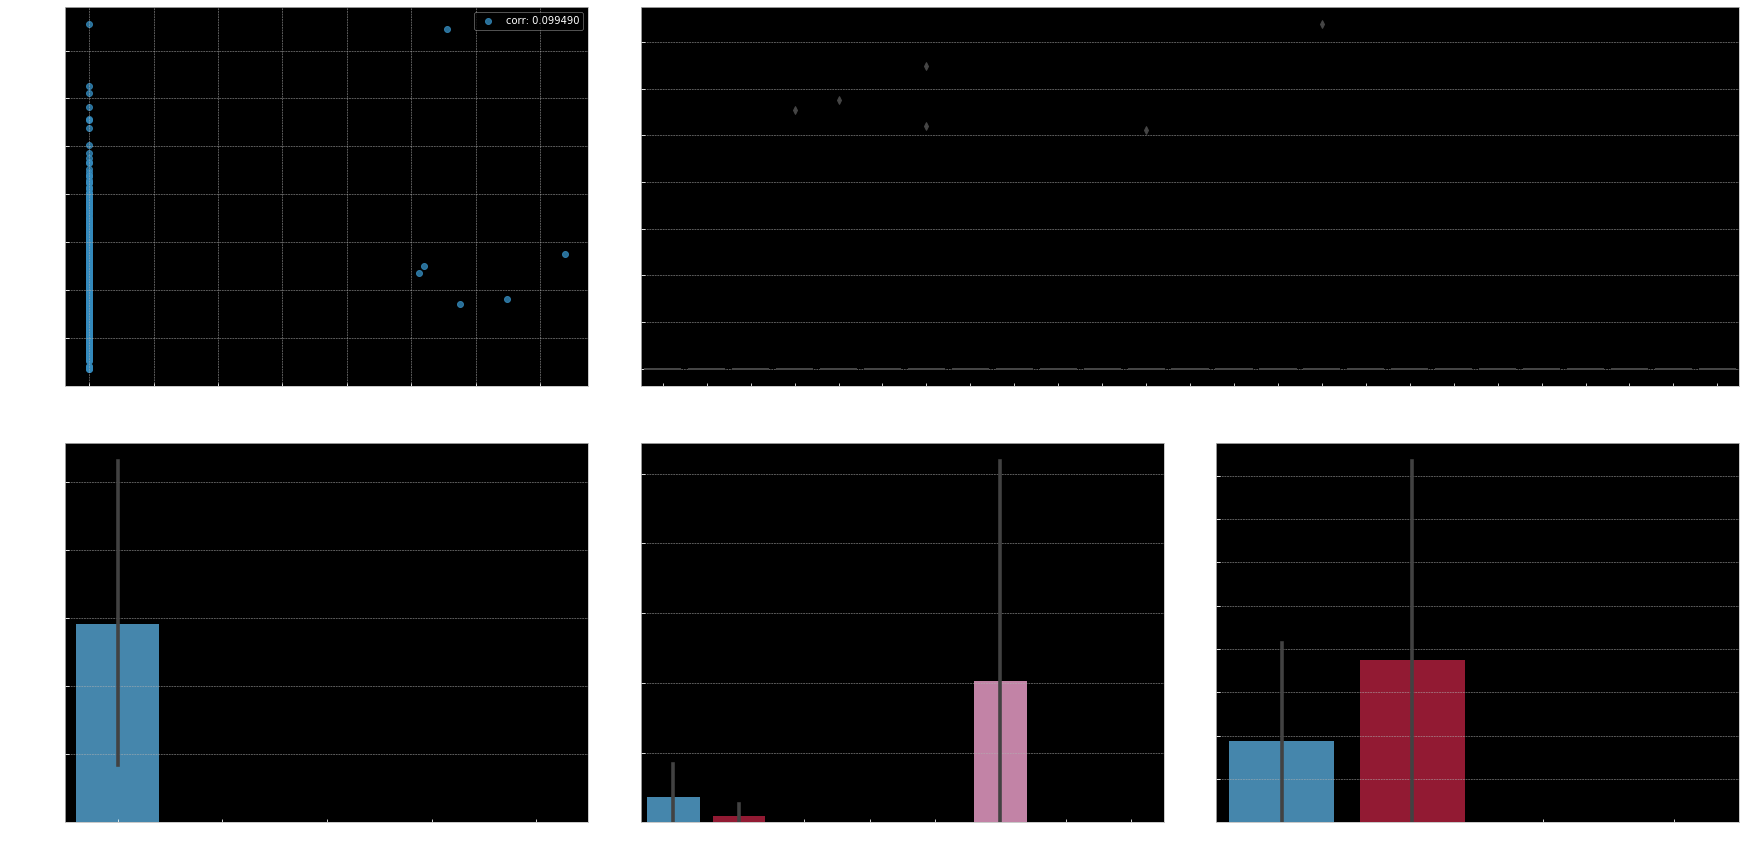

In [80]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['PoolArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="PoolArea", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="PoolArea", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="PoolArea", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="PoolArea", data=train);


We see almost 0 correlation due to the high number of houses without a pool.


#### Pool quality.

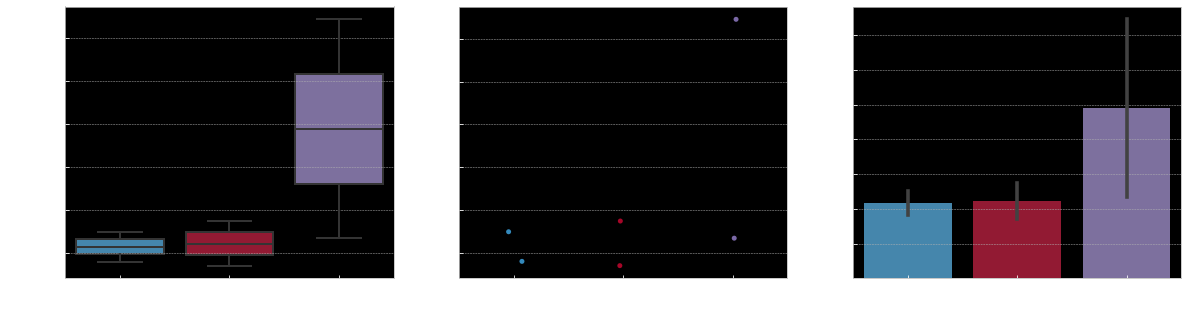

In [81]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"])

plt.subplot(1, 3, 2)
sns.stripplot(x="PoolQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "Gd", "Ex"]);

plt.subplot(1, 3, 3)
sns.barplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"]);


Due to not many houses having a pool, we see very low numbers of observations for each class.
Since this does not hold much information this feature, I will simply remove it

#### Fence quality.

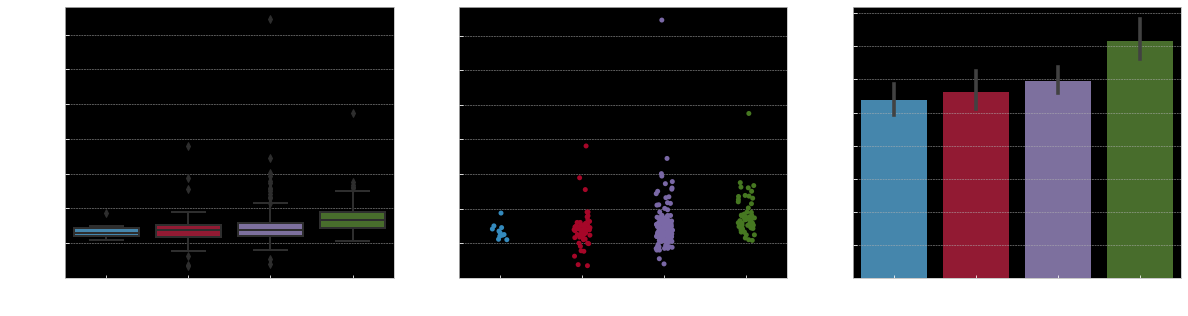

In [82]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"])

plt.subplot(1, 3, 2)
sns.stripplot(x="Fence", y="SalePrice", data=train, size = 5, jitter = True, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"]);

plt.subplot(1, 3, 3)
sns.barplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"]);


Here we see that the houses with the most privacy have the highest average SalePrice.
There seems to be a slight order within the classes, however some of the class descriptions are slightly ambiguous

## Location

#### Identifies the general zoning classification of the sale.

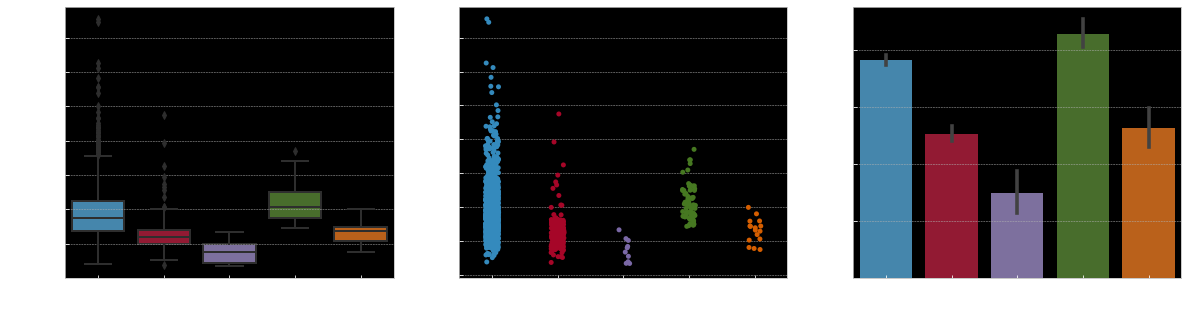

In [83]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSZoning", y="SalePrice", data=train, order = ["RL", "RM", "C (all)", "FV", "RH"])

plt.subplot(1, 3, 2)
sns.stripplot(x="MSZoning", y="SalePrice", data=train, size = 5, jitter = True, order = ["RL", "RM", "C (all)", "FV", "RH"]);

plt.subplot(1, 3, 3)
sns.barplot(x="MSZoning", y="SalePrice", data=train, order = ["RL", "RM", "C (all)", "FV", "RH"]);

Since this a categorical feature without order, and each of the classes has a very different range and average for SalePrice, I will create dummy features here.


#### Physical locations within Ames city limits.

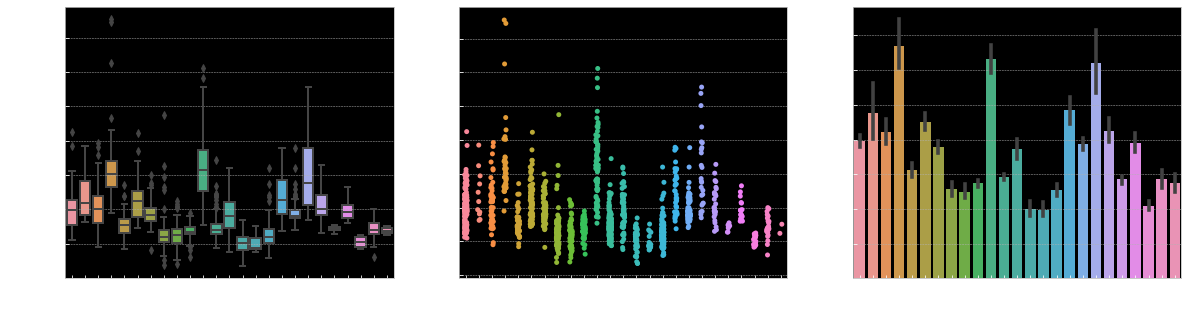

In [84]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Neighborhood", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Neighborhood", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Neighborhood", y="SalePrice", data=train);

Neighborhood clearly has an important contribution towards SalePrice, since we see such high values for certain areas and low values for others.

#### Proximity to various conditions.

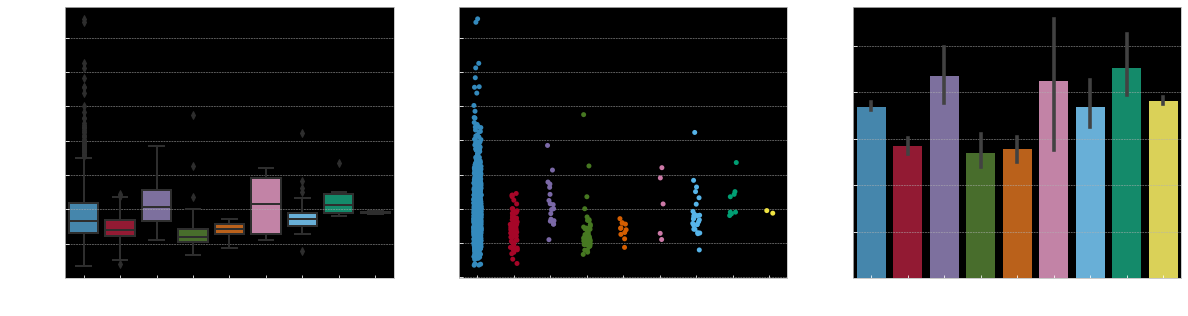

In [85]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition1", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition1", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition1", y="SalePrice", data=train);

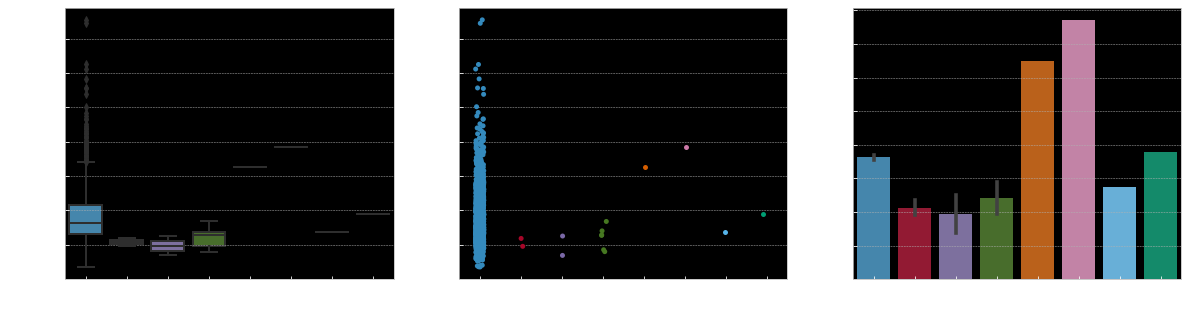

In [86]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition2", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition2", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition2", y="SalePrice", data=train);

Since this feature is based around local features, it is understandable that having more desirable things, like a parks... nearby are a factor that would contribute towards a higher SalePrice.


## Land

#### Linear feet of street connected to property.

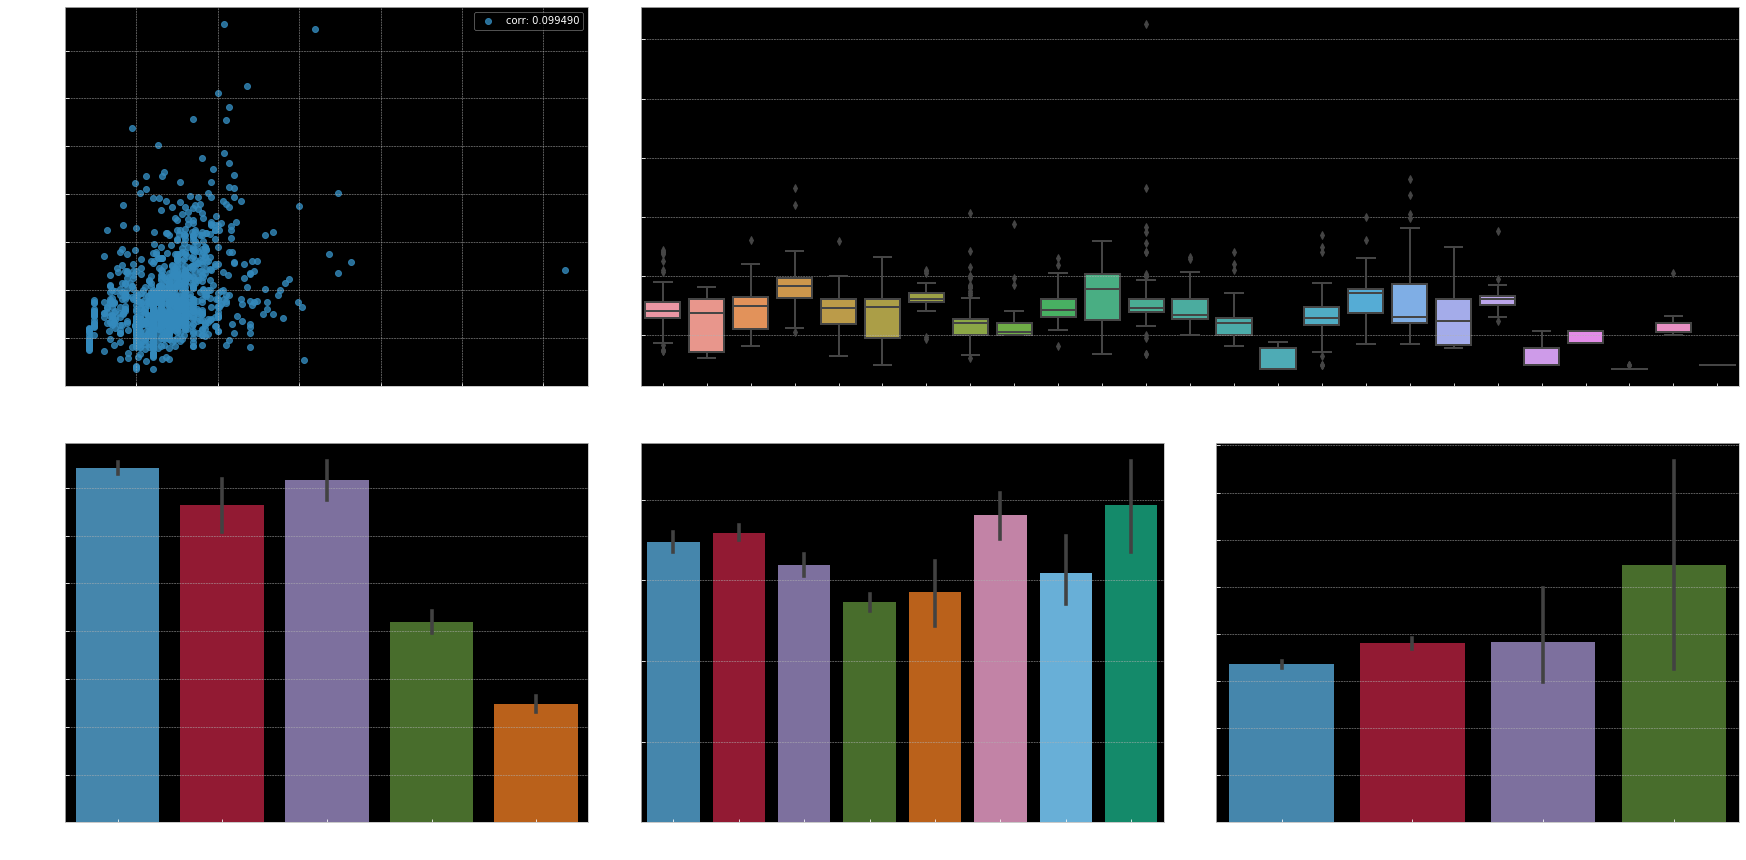

In [87]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotFrontage'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotFrontage", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotFrontage", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotFrontage", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotFrontage", data=train);

This feature seems to be fairly randomly distributed against SalePrice without any significant correlation.
LotFrontage doesn't seem to vary too much based on "Neighborhood", but the "BldgType" does seem to have a affect on the average LotFrontage

#### Lot size in square feet

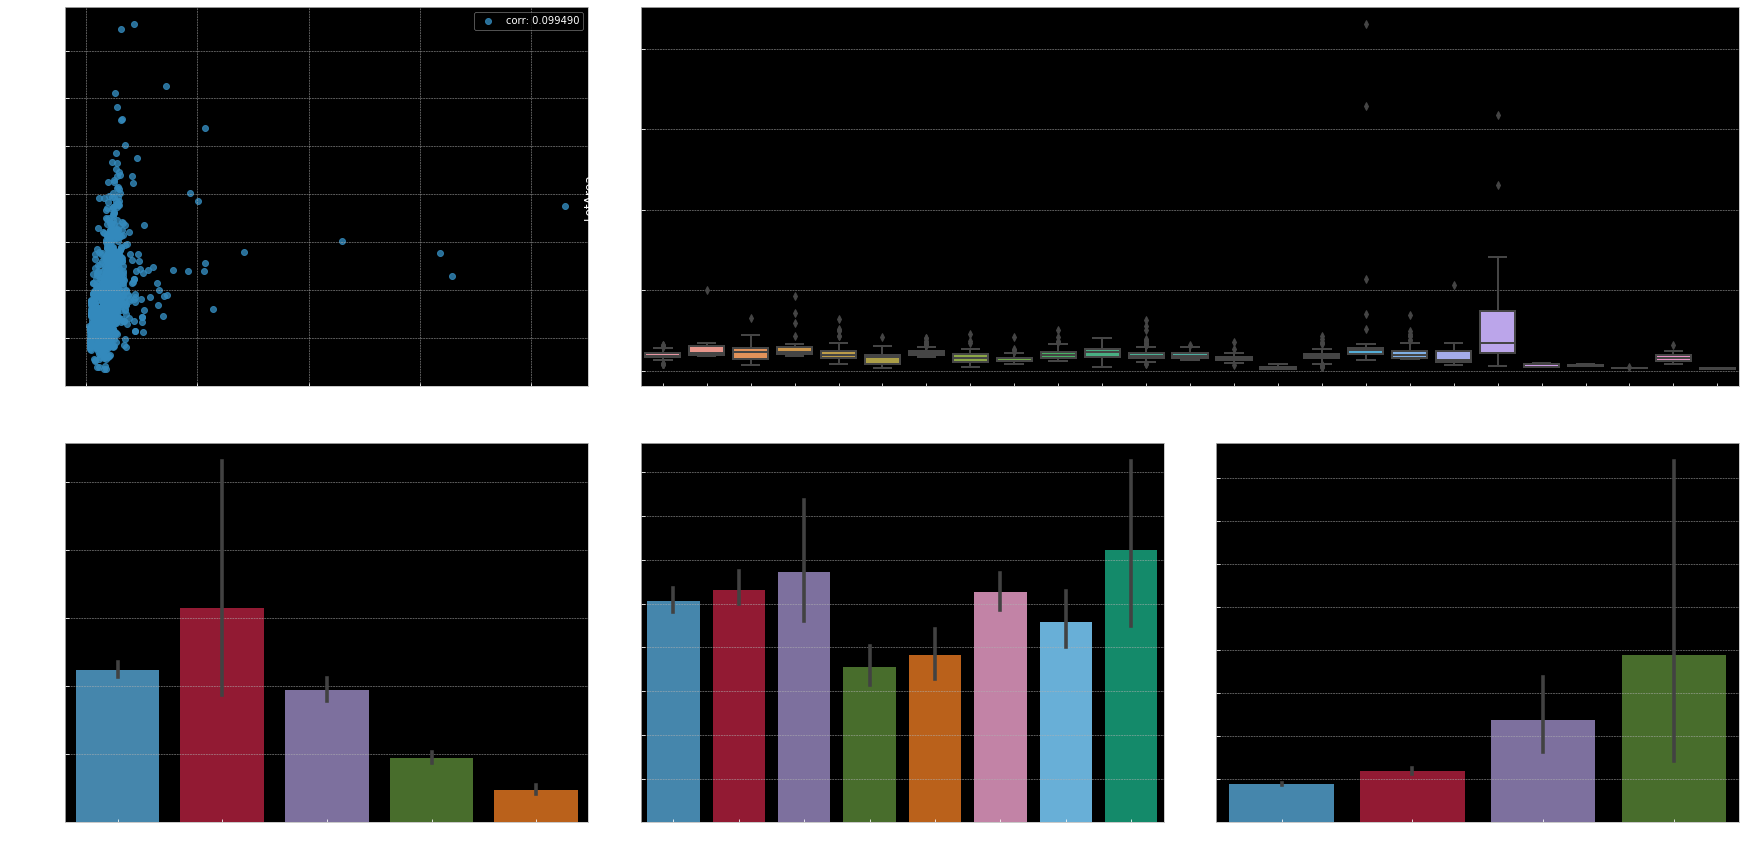

In [88]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotArea", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotArea", data=train)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotArea", data=train)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotArea", data=train);

This feature shows a high correlation but it is very positively skewed.


#### General shape of property.

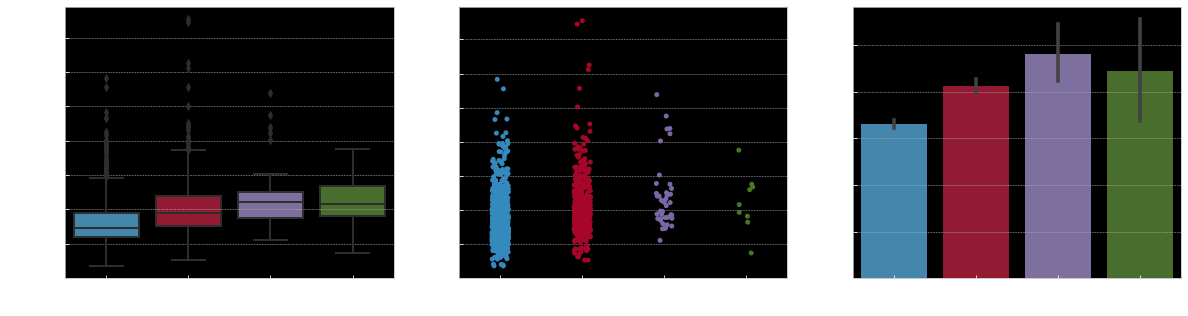

In [89]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotShape", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotShape", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="LotShape", y="SalePrice", data=train);

Clearly we see some extreme values for some categories and a varying SalePrice across classes.
"Reg" and "IR1" have the highest frequency of data points within them.


#### Flatness of the property

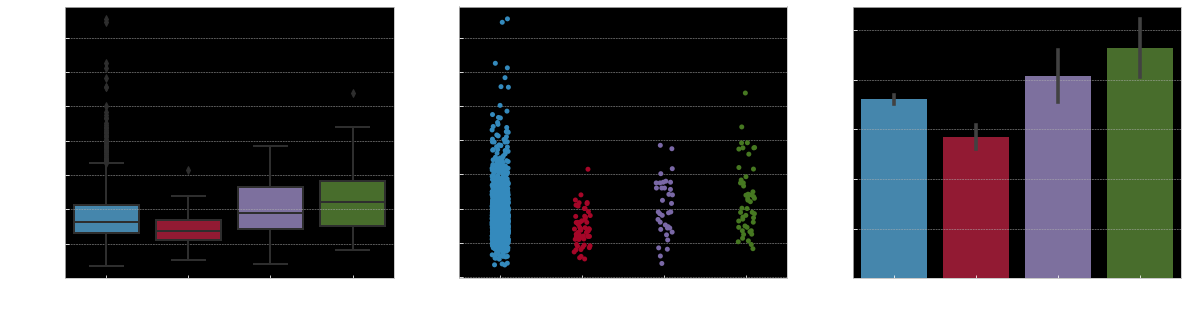

In [90]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandContour", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandContour", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="LandContour", y="SalePrice", data=train);

Most houses are indeed on a flat contour, however the houses with the highest SalePrice seem to come from properties on a hill interestingly.


#### Lot configuration

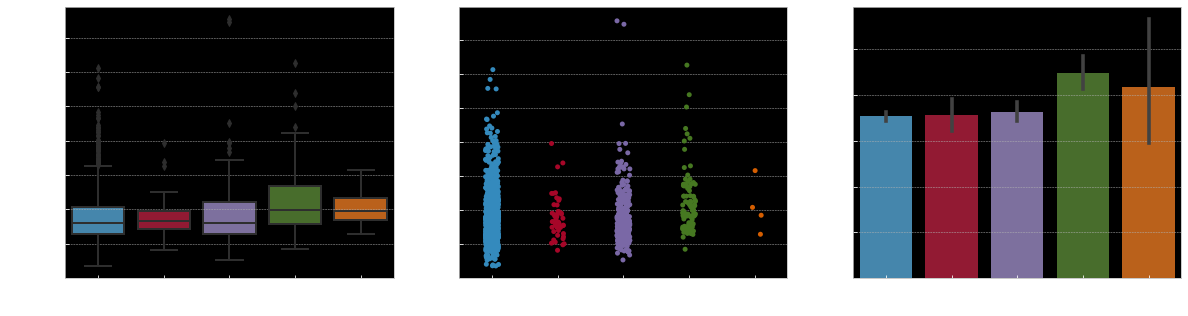

In [91]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotConfig", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotConfig", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="LotConfig", y="SalePrice", data=train);

Cul de sac's seem to boast the highest average prices within Ames, however most houses are positioned inside or on the corner of the lot.

#### Slope of property

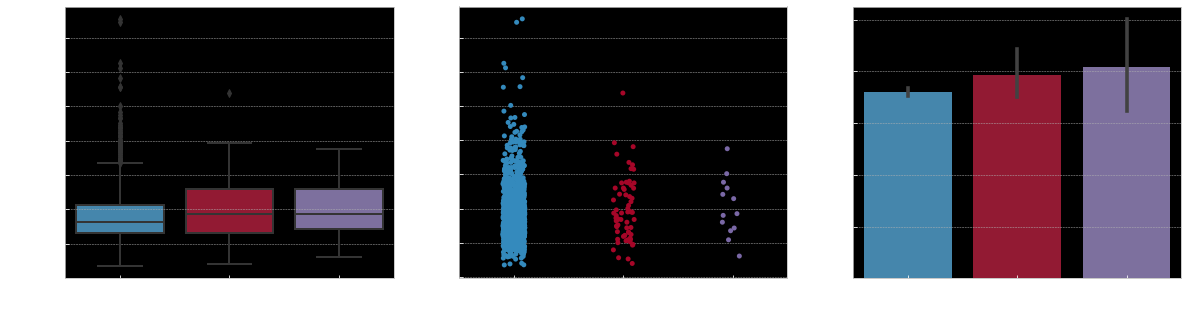

In [92]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandSlope", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandSlope", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="LandSlope", y="SalePrice", data=train);

We see that most houses have a gentle slope of land and overall, the severity of the slope doesn't appear to have much of an impact on SalePrice.

## Access

#### Type of road access to the property

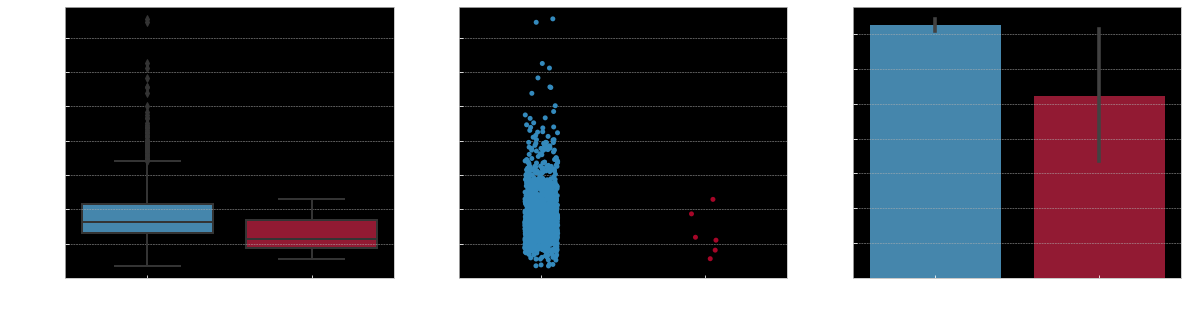

In [93]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Street", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Street", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Street", y="SalePrice", data=train);

With such a lower number of observations being assigned to the class "Grvl" it is redundant within the model.
Hence, I will drop this feature.


#### Type of alley access to the property.

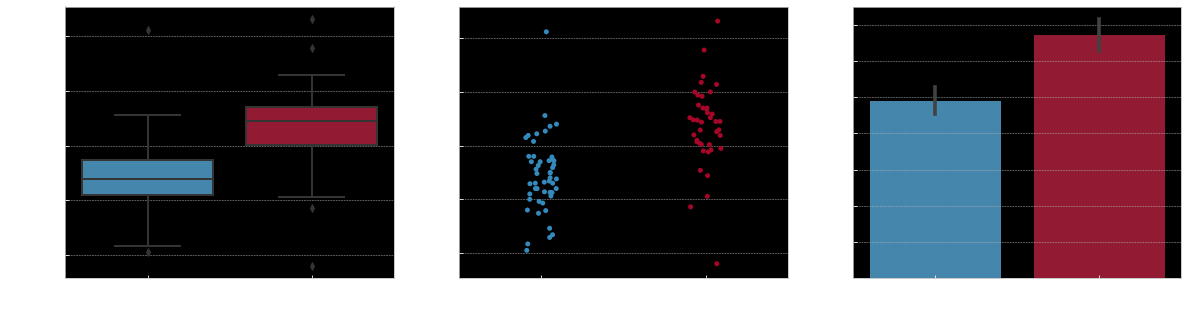

In [94]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Alley", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Alley", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Alley", y="SalePrice", data=train);

Here we see a fairly even split between to two classes in terms of frequency, but a much higher average SalePrice for Paved alleys as opposed to Gravel ones.
Hence, this seems as though it could be a good predictor. 

#### Paved driveway.

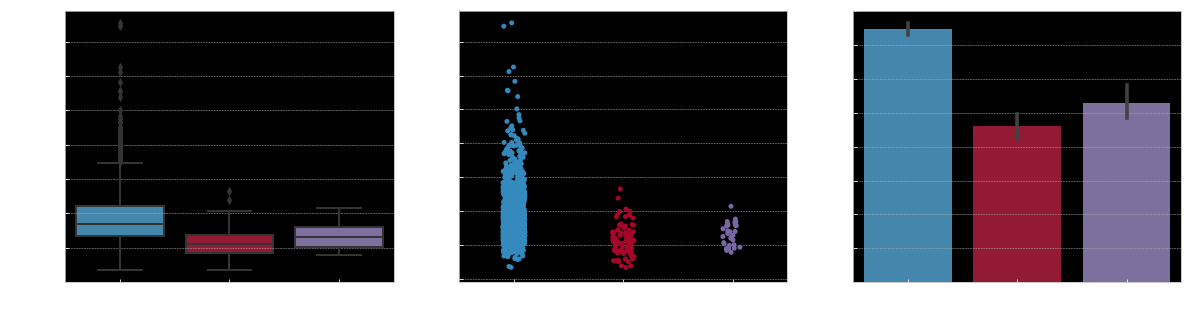

In [95]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PavedDrive", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="PavedDrive", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="PavedDrive", y="SalePrice", data=train);

Here we see the highest average price being demanded from houses with a paved driveway, and most houses in this srea seem to have one.

## Utilities

#### Type of heating.

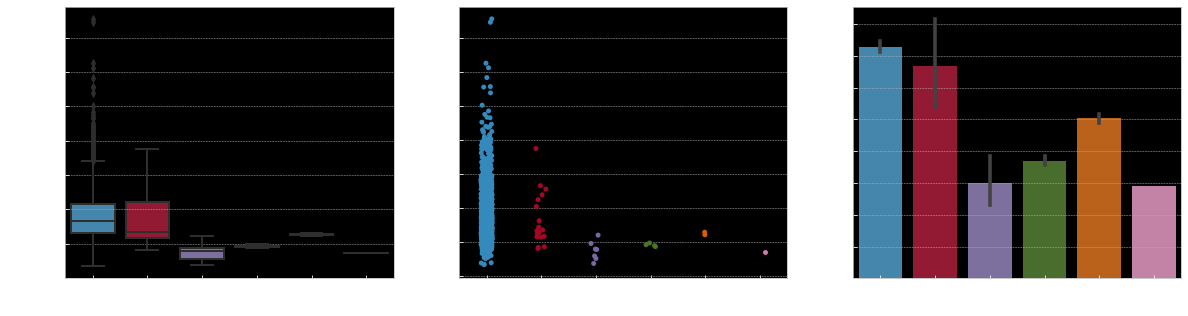

In [96]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Heating", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Heating", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Heating", y="SalePrice", data=train);

We see the highest frequency and highest average SalePrice coming from "GasA" and a very low frequency from all other classes.

#### Heating quality and condition.

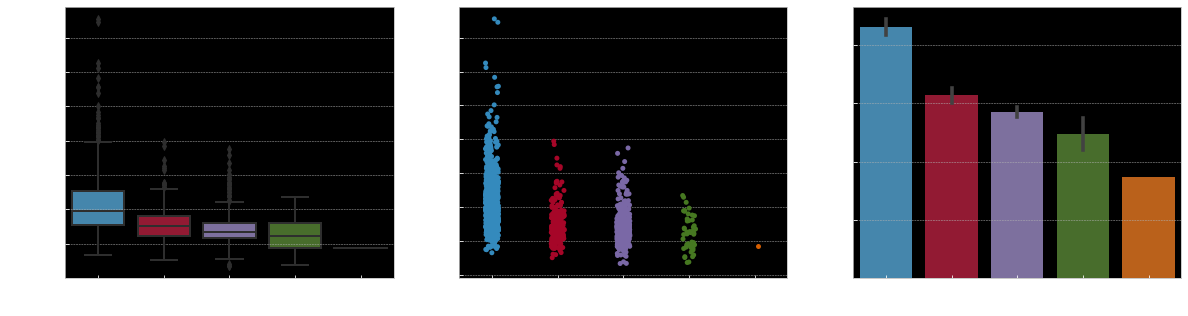

In [97]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HeatingQC", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="HeatingQC", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="HeatingQC", y="SalePrice", data=train);

Here we see a positive correlation with SalePrice as the heating quality increases. With "Ex" bringing the highest average SalePrice.

We also see a high number of houses with this heating quality too, which means most houses had very good heating!

#### Central air conditioning.

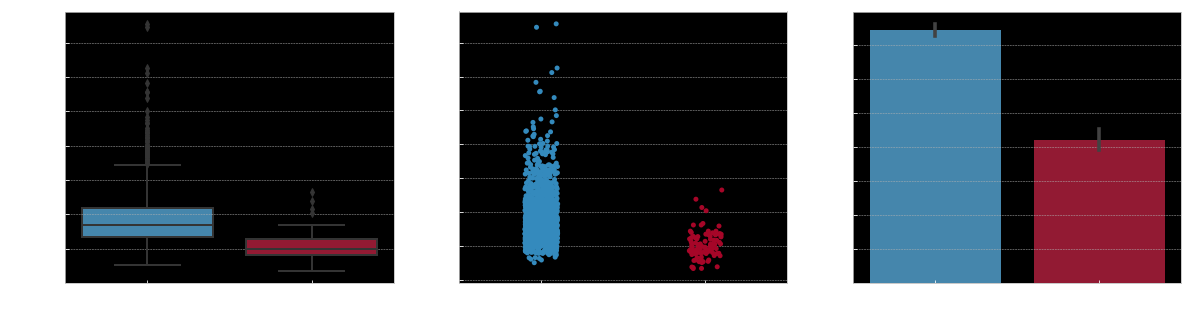

In [98]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="CentralAir", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="CentralAir", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="CentralAir", y="SalePrice", data=train);

We see that houses with central air conditioning are able to demand a higher average SalePrice than ones without.

#### Electrical system.

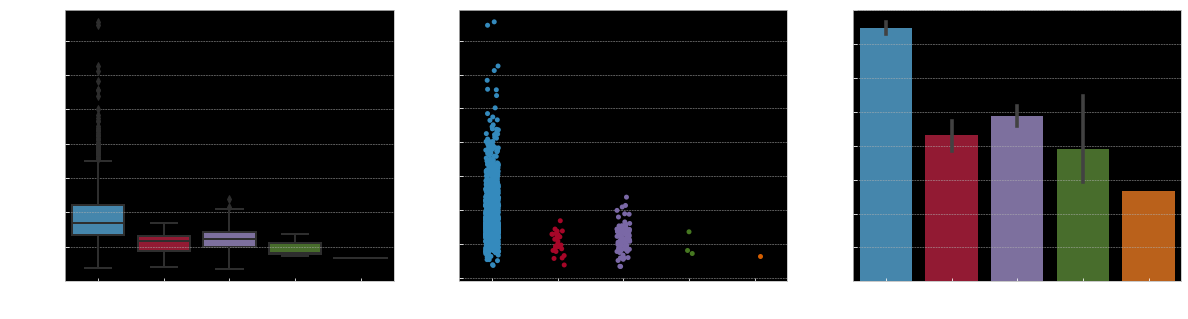

In [99]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Electrical", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="Electrical", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="Electrical", y="SalePrice", data=train);

We see the highest average SalePrice coming from houses with "SBrkr" electrics, and these are also the most frequent electrical systems installed in the houses from this area.

We have 2 categories in particular that have very low frequencies, "FuseP" and "Mix".

## Miscellaneous

#### Miscellaneous feature not covered in other categories.

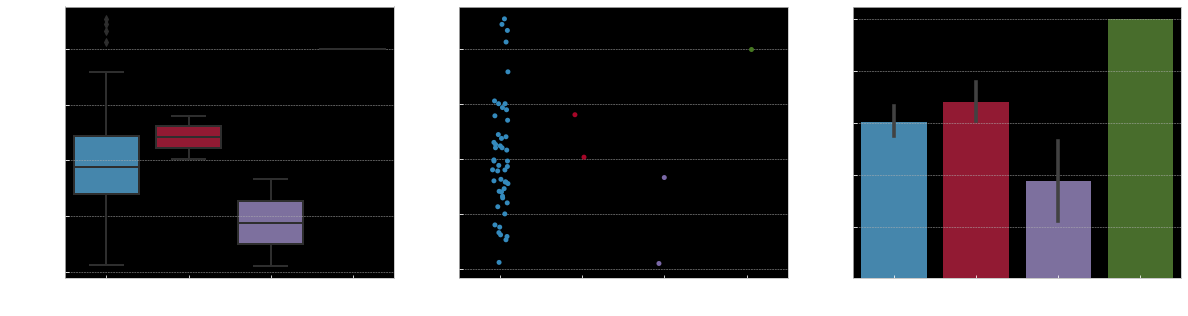

In [100]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MiscFeature", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="MiscFeature", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="MiscFeature", y="SalePrice", data=train);

We can see here that only a low number of houses in this area with any miscalleanous features. Hence, I do not believe that this feature holds much.
Therefore I will drop this feature along with MiscVal

#### Month sold (MM).

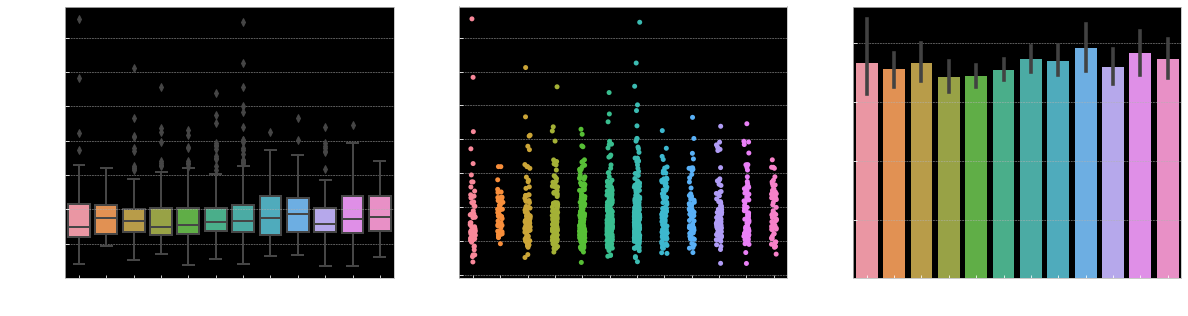

In [101]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MoSold", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="MoSold", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="MoSold", y="SalePrice", data=train);

Although this feature is a numeric feature, it should really be a category.
We can see that there is no real indicator as to any months that consistetly sold houses of a higher price, however there does seem to be a fairly even distribution of values between classes.

#### Year sold 

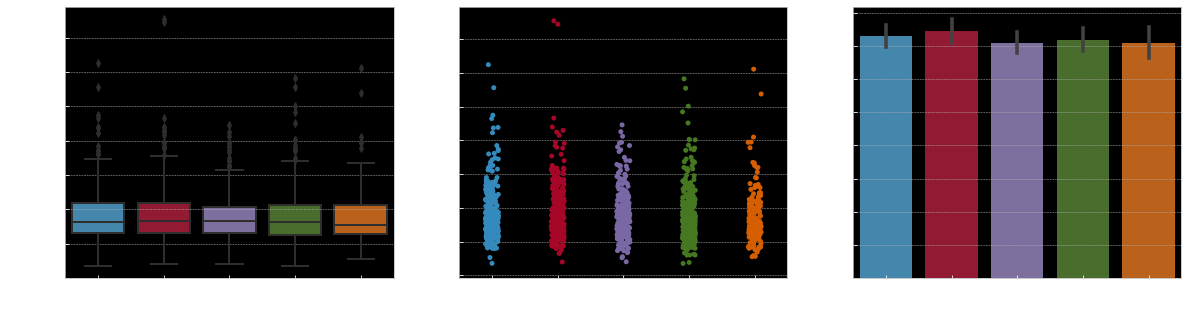

In [102]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YrSold", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="YrSold", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="YrSold", y="SalePrice", data=train);

Here we see just a 5 year time period of which the houses in this dataset were sold.
There is a n even distribution of values between each class, and each year has a very similar average SalePrice.


#### Type of sale.

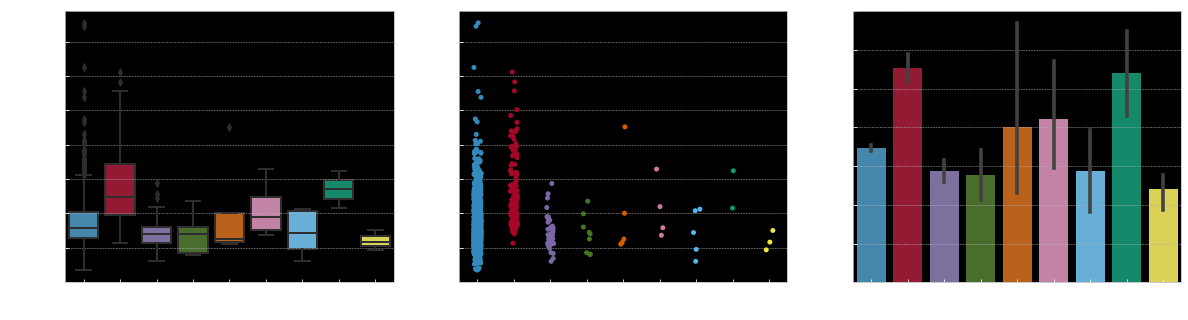

In [103]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleType", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleType", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleType", y="SalePrice", data=train);

Most houses were sold under the "WD" category, being a conventional sale, however the highest SalePrice was seen from houses that were sold as houses that were brand new and just sold.


#### Condition of sale.

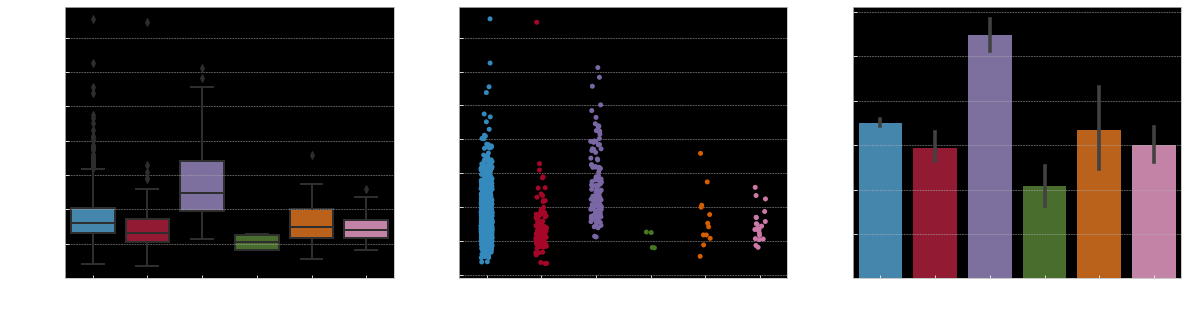

In [104]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleCondition", y="SalePrice", data=train)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleCondition", y="SalePrice", data=train, size = 5, jitter = True);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleCondition", y="SalePrice", data=train);

Here we see the largest average SalePrice being associated with partial sales, and the most frequent sale seems to be the normal sales.


In [105]:
data.to_csv('data.csv',index=False)

In [106]:
# train["SalePrice"] = np.log(train["SalePrice"])

In [107]:
# y_train = train.SalePrice.values

In [108]:
# # transforming year and month into categorical features
# data['YrSold'] = data['YrSold'].astype(str)
# data['MoSold'] = data['MoSold'].astype(str)

In [109]:
# # gonna try putting overall condition as categorical
# data['OverallCond'] = data['OverallCond'].astype(str)
# data['OverallQual'] = data['OverallQual'].astype(str)

In [110]:
# # MSSubClass should be categorical as well
# data['MSSubClass'] = data['MSSubClass'].astype(str)

In [111]:
# # Overall SF? we have TotalBsmtSF, 1stFlrSF and 2ndFlrSF 
# # might be worth putting them together into a "overall SF"category?
# data['OverallSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']

In [112]:
# data['Remod_Diff'] =  data['YearRemodAdd'] -  data['YearBuilt']

In [113]:
# category = ('LotShape', 'LandSlope', 'OverallQual','OverallCond', 'ExterQual', 'ExterCond',
#             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
#             'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
#             'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence')

# for c in category:
#     lbl = LabelEncoder()
#     lbl.fit(list(data[c].values))
#     data[c] = lbl.transform(list(data[c].values))

In [114]:
# numerical = data.dtypes[data.dtypes != "object"].index
# skewed = data[numerical].apply(lambda x: x.skew()).sort_values(ascending=False)
# skewdf = pd.DataFrame({'Skew': skewed})
# skewdf = skewdf[(skewdf)>0.5]
# skewed = skewdf.index
# lam = 0.15
# for feat in skewed:
#     data[feat] = boxcox1p(data[feat], lam)

In [115]:
# Nomial_categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
#        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
#        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
#        'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature',
#        'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

# for c in Nomial_categories:
#     data = pd.get_dummies(data, columns = [c], prefix=c)

In [116]:
# # First, re-create the training and test datasets
# train = data[:ntrain]
# test = data[ntrain:]

# print(train.shape)
# print(test.shape)

In [117]:
# train.to_csv('train_cleaning.csv',index=False)
# test.to_csv('test_cleaning.csv',index=False)

In [118]:
# train = pd.read_csv('train_cleaning.csv')
# test = pd.read_csv('test_cleaning.csv')

In [119]:
# # Load libraries
# from sklearn.linear_model    import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
# from sklearn.ensemble        import RandomForestRegressor as rfr,  GradientBoostingRegressor
# from sklearn.kernel_ridge    import KernelRidge
# from sklearn.pipeline        import make_pipeline
# from sklearn.preprocessing   import RobustScaler
# from sklearn.base            import BaseEstimator, TransformerMixin, RegressorMixin, clone
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics         import mean_squared_error

In [120]:
# n_folds = 10
# #this looks better, lets me use kfolds
# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(train)
#     rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [121]:
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00099, random_state=1))

In [122]:
# score = rmsle_cv(lasso)
# print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))